# Imports

In [1]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
from scipy import stats
import graphviz
import astropy.units as u

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from functools import partial

import os
import warnings
#os.environ["MKL_THREADING_LAYER"] = "GNU"
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-dark-palette')

/tmp/ipykernel_26218/1667230561.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [3]:
plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

# Data 

## Tess

In [4]:
#sectors times, 41-48
from astropy.time import Time
sectors = ['2019-07-18T20:30:00', '2019-08-14T17:05:00', '2020-01-21T22:25:00', '2020-02-18T06:55:00', '2021-07-24T11:45:00','2021-08-20T02:05:00','2022-01-28T10:25:00','2022-02-25T11:50:00']
sectors_times = Time(sectors, format='fits')
sectors_times_btjd = sectors_times.jd-2457000
sectors_times_btjd

array([1683.35416667, 1710.21180556, 1870.43402778, 1897.78819444,
       2419.98958333, 2446.58680556, 2607.93402778, 2635.99305556])

In [5]:
lk.search_targetpixelfile('TIC 99869022')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,TESS-SPOC,1800,99869022,0.0
1,TESS Sector 21,2020,TESS-SPOC,1800,99869022,0.0
2,TESS Sector 41,2021,SPOC,120,99869022,0.0
3,TESS Sector 41,2021,TESS-SPOC,600,99869022,0.0
4,TESS Sector 48,2022,SPOC,120,99869022,0.0
5,TESS Sector 48,2022,TESS-SPOC,600,99869022,0.0


In [6]:
tpf = lk.search_targetpixelfile('TIC 99869022', exptime='short', sector=41).download_all(quality_bitmask='hard')

<Axes: title={'center': 'Target ID: 99869022, Cadence: 858625'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

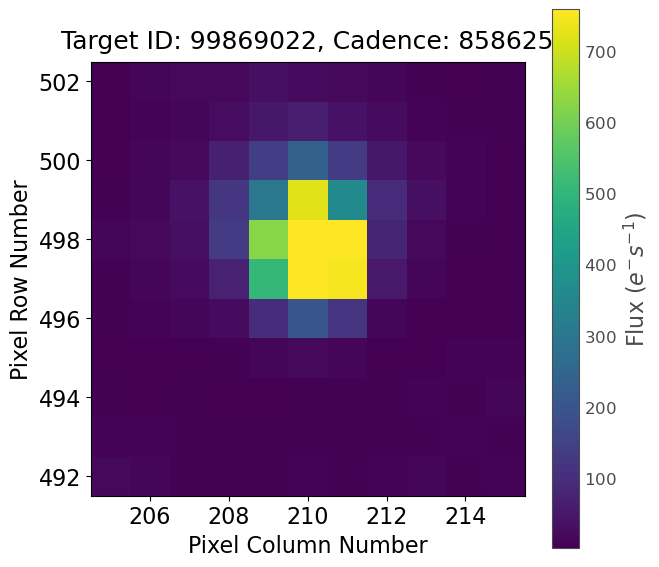

In [7]:
tpf.plot()

In [8]:
# !python ~/Descargas/tpfplotter/tpfplotter.py 99869022 --maglim 6 --sector 48

In [9]:
lk.search_lightcurve('TIC 99869022')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector,2019,DIAMANTE,1800,99869022,0.0
1,TESS Sector 14,2019,TESS-SPOC,1800,99869022,0.0
2,TESS Sector 14,2019,QLP,1800,99869022,0.0
3,TESS Sector 14,2019,TASOC,1800,99869022,0.0
4,TESS Sector 14,2019,TASOC,1800,99869022,0.0
5,TESS Sector 21,2020,TESS-SPOC,1800,99869022,0.0
6,TESS Sector 21,2020,QLP,1800,99869022,0.0
7,TESS Sector 41,2021,SPOC,120,99869022,0.0
8,TESS Sector 41,2021,TESS-SPOC,600,99869022,0.0


In [10]:
lk.search_lightcurve('TIC 99869022', exptime=1800)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector,2019,DIAMANTE,1800,99869022,0.0
1,TESS Sector 14,2019,TESS-SPOC,1800,99869022,0.0
2,TESS Sector 14,2019,QLP,1800,99869022,0.0
3,TESS Sector 14,2019,TASOC,1800,99869022,0.0
4,TESS Sector 14,2019,TASOC,1800,99869022,0.0
5,TESS Sector 21,2020,TESS-SPOC,1800,99869022,0.0
6,TESS Sector 21,2020,QLP,1800,99869022,0.0


In [11]:
lc_file_long = lk.search_lightcurve('TIC 99869022', exptime=1800, author='TESS-SPOC').download_all(flux_column="pdcsap_flux")

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

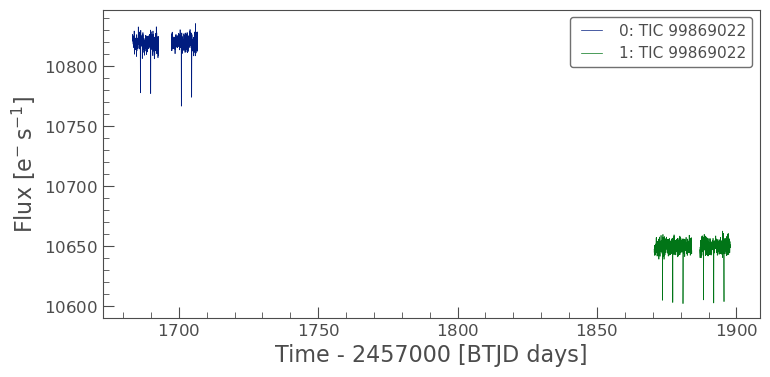

In [12]:
lc_file_long.plot()

Text(0, 0.5, 'Relative flux')

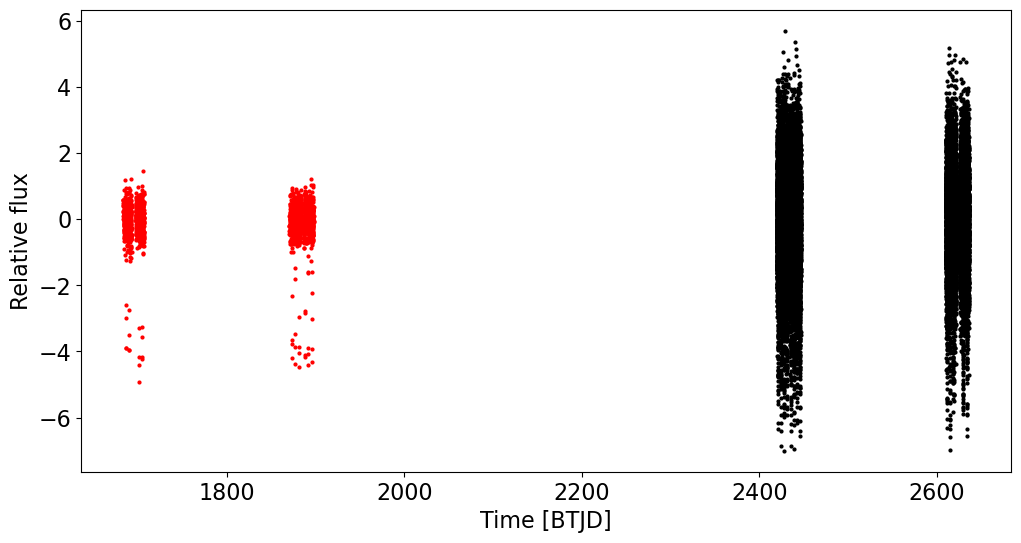

In [13]:
lc_file = lk.search_lightcurve('TIC 99869022', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

lc_long = lc_file_long.stitch().remove_nans().normalize()
time_long = lc_long.time.value
flux_long = lc_long.flux

with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header
with fits.open(lc_file_long[0].filename) as hdu:
    hdr_long = hdu[1].header

texp_long = hdr_long["FRAMETIM"] * hdr_long["NUM_FRM"]
texp_long /= 60.0 * 60.0 * 24.0
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64) 

xlong_ = np.ascontiguousarray(time_long - ref_time, dtype=np.float64)
ylong_ = np.ascontiguousarray(1e3 * (flux_long - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerrlong_ = np.ascontiguousarray(1e3 * lc_long.flux_err, dtype=np.float64)

plt.figure(figsize=(12, 6))
plt.plot(time, y_, "o", color='black',markersize=2)
plt.plot(time_long, ylong_, "o", color='red',markersize=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Relative flux")
#_ = plt.xlim(x_.min(), x_.max())
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

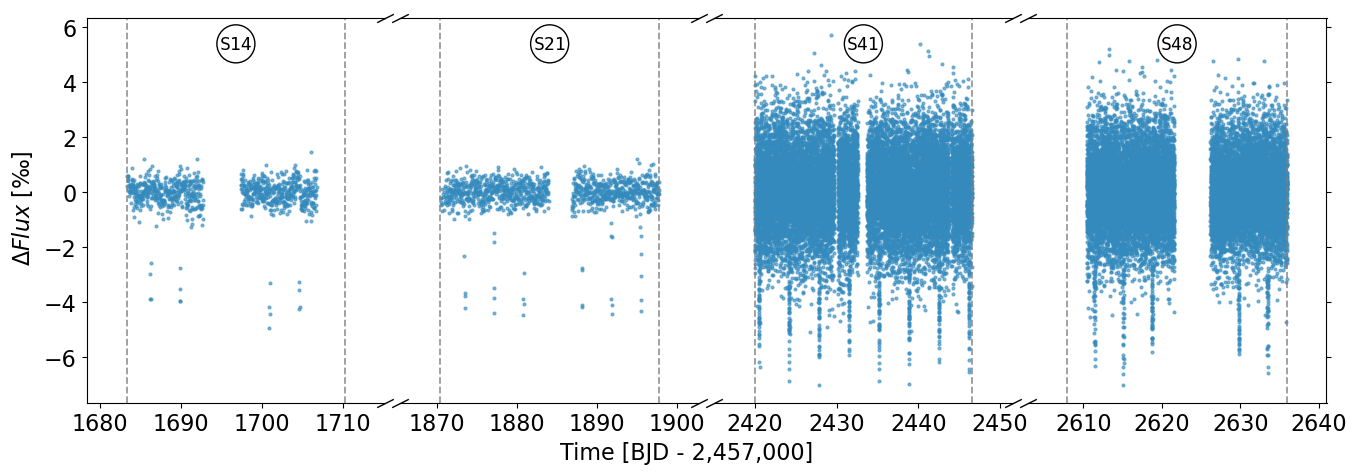

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharey=True, figsize=(16,5), gridspec_kw={'width_ratios': [1, 1,1,1]})
fig.subplots_adjust(wspace=0.05)
ax1.plot(time_long, ylong_, "o", color='#348ABD', markersize=2, alpha=0.6)
ax2.plot(time_long, ylong_, "o", color='#348ABD', markersize=2, alpha=0.6)
ax3.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.6)
ax4.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.6)
off=5
ax1.set_xlim(sectors_times_btjd[0]-off, sectors_times_btjd[1]+off)  
ax2.set_xlim(sectors_times_btjd[2]-off, sectors_times_btjd[3]+off)  
ax3.set_xlim(sectors_times_btjd[4]-off, sectors_times_btjd[5]+off)
ax4.set_xlim(sectors_times_btjd[6]-off, sectors_times_btjd[7]+off)
#ax2.set_xticks([2600, 2650, 2700])
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax2.spines.right.set_visible(False)
ax3.spines.left.set_visible(False)
ax3.spines.right.set_visible(False)
ax4.spines.left.set_visible(False)

ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax3.yaxis.tick_right()
ax4.yaxis.tick_right()
ax1.tick_params(labelright=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, 
                labelright=False, labelleft=False)
ax3.tick_params(axis='y', which='both', left=False, right=False, 
                labelright=False, labelleft=False)
ax4.tick_params(labelleft=False)

d = .5  
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)
ax3.plot([1, 1], [0, 1], transform=ax3.transAxes, **kwargs)
ax4.plot([0, 0], [1, 0], transform=ax4.transAxes, **kwargs)
for i in sectors_times_btjd[:2]:
    ax1.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[2:4]:
    ax2.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[4:6]:
    ax3.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[6:]:
    ax4.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
fig.text(0.5, 0.01, "Time [BJD - 2,457,000]", ha='center', va='center')
fig.text(0.085, 0.5, u'$\Delta Flux$ [‰]', ha='center', va='center', rotation='vertical')
ax1.text(sectors_times_btjd[0]+(sectors_times_btjd[1]-sectors_times_btjd[0])/2, 5.38, 
    "S14", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax2.text(sectors_times_btjd[2]+(sectors_times_btjd[3]-sectors_times_btjd[2])/2, 5.38, 
    "S21", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle, pad=0.15", fc='white', lw=1))
ax3.text(sectors_times_btjd[4]+(sectors_times_btjd[5]-sectors_times_btjd[4])/2, 5.38, 
    "S41", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle, pad=0.15", fc='white', lw=1))
ax4.text(sectors_times_btjd[6]+(sectors_times_btjd[7]-sectors_times_btjd[6])/2, 5.38, 
    "S48", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle, pad=0.15", fc='white', lw=1))
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

BLS

In [15]:
xt = np.concatenate((xlong_, x_), axis=0)
yt = np.concatenate((ylong_, y_), axis=0)
yerrt = np.concatenate((yerrlong_, yerr_), axis=0)

In [16]:
period_grid = np.exp(np.linspace(np.log(1), np.log(15), 30000)) #1 y 15 -- 1 y 30
durations = np.exp(np.linspace(np.log(0.01), np.log(0.2), 100))

bls = BoxLeastSquares(x_, y_, yerr_)
bls_power = bls.power(period_grid, durations, oversample=30)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
bls_duration = bls_power.duration[index]

print('bls period:', bls_period)
print('bls t0:', bls_t0)
print('bls depth:', bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)
print('bls duration:', bls_duration*24)

bls period: 3.6716075752767074
bls t0: -107.45478045582509
bls depth: 3.7459651206817273
ref_time: 2527.9875009679236
epoch: 2420.5327205120984
bls duration: 1.9360000000000006


In [17]:
# tess project fit
spoc_depth = 4.340 
spoc_duration = 2.149/24
spoc_period = 3.671463

In [18]:
# 50000, 1000, 30
# bls period: 3.6714776169735264
# bls t0: -107.44944712249175
# bls depth: 3.736413756919435
# ref_time: 2527.9875009679236
# epoch: 2420.538053845432
# bls duration: 1.9840000000000007

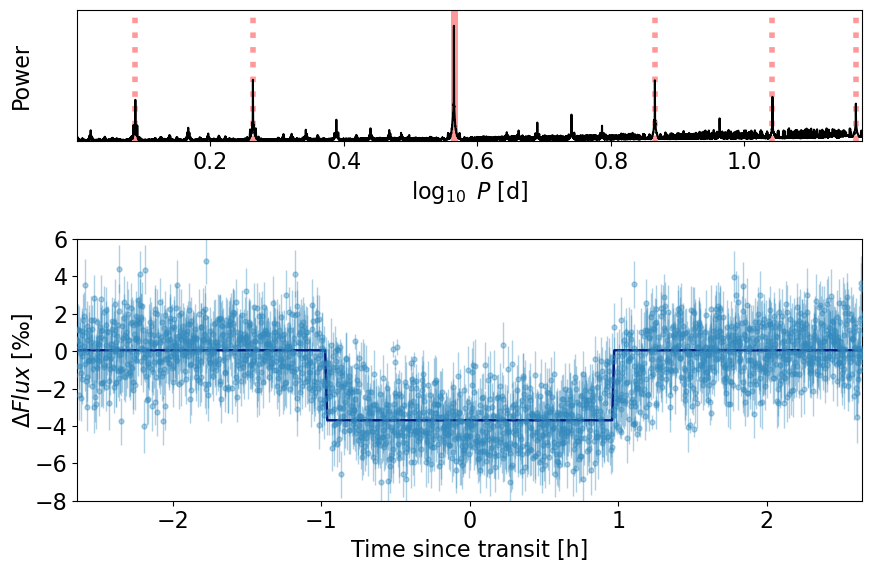

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.35)

ax1.axvline(np.log10(bls_period), color="red", lw=5, alpha=0.4)
ax1.axvline(np.log10(bls_period/2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/3), linestyle='dotted', color="red", lw=4, alpha=0.4)
#ax1.axvline(np.log10(bls_period/4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.plot(np.log10(bls_power.period), bls_power.power, "k")
ax1.set_ylim(0,3500)
ax1.set_ylabel("Power", labelpad=32)
ax1.set_yticks([])
ax1.set_xlim(np.log10(period_grid.min())+0.001, np.log10(period_grid.max()))
ax1.set_xlabel(r"$\log_{10}~ P$ [d]")

# Plot the folded transit
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
x_fold_long = (xlong_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
xt_fold = (xt - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
# x_fold_ = (x_ - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# x_fold_long = (xlong_ - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# xt_fold = (xt - t0_ + 0.5 * p_) % p_ - 0.5 * p_

# ax2.plot(x_fold_long*24, ylong_, ".", alpha=0.6, ms=4, color='r', zorder=102)
# ax2.errorbar(x_fold_long*24, ylong_, yerr=yerrlong_, color='r', fmt="none", capsize=0, elinewidth=1, zorder=10000, alpha=0.5)
# ax2.plot(x_fold_*24, y_, ".", alpha=0.7, ms=5, color='#348ABD', zorder=101)
# ax2.errorbar(x_fold_*24, y_, yerr=yerr_, fmt="none", color='#348ABD', elinewidth=1, alpha=0.2, capsize=0, zorder=10000)
ax2.plot(xt_fold*24, yt, ".", alpha=0.4, ms=7, color='#348ABD', zorder=100)
ax2.errorbar(xt_fold*24, yt, yerr=yerrt, fmt="none", color='#348ABD', elinewidth=1, alpha=0.4, capsize=0)
ax2.set_ylim(-8,6)
ax2.set_yticks([-8,-6,-4,-2,0,2,4,6])

#Overplot the phase binned light curve
lcc = lk.LightCurve(time=xt_fold, flux=yt, flux_err=yerrt)
lcc_binned = lcc.bin(time_bin_size=0.01)
ax2.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, capsize=2, alpha=0.8)
ax2.set_xlim(-0.11*24, 0.11*24)
ax2.set_ylabel(u'$\Delta Flux$ [‰]', labelpad=0)
_ = ax2.set_xlabel("Time since transit [h]")

# plot the BLS model
x_bin = np.linspace(-0.3, 0.3, 1000)
f = bls.model(x_bin + bls_t0, bls_period, bls_duration, bls_t0)
ax2.plot(x_bin*24, f, lw=1.75)
plt.tight_layout()

#plt.savefig('bls_paper_1199.png', dpi=300, bbox_inches='tight', facecolor='white')

Text(0, 0.5, 'relative flux [ppt]')

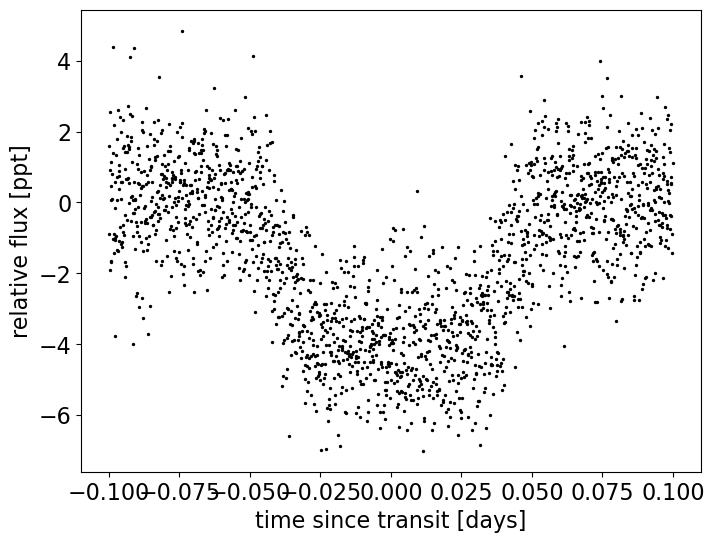

In [20]:
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)
transit_mask_long = bls.transit_mask(xlong_, bls_period, 0.2, bls_t0)
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]
yerr = yerr_[transit_mask]

xlong = xlong_[transit_mask_long]
ylong = ylong_[transit_mask_long]
yerrlong = yerrlong_[transit_mask_long]

plt.scatter(x_fold, y, c='k', s=2)

plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
#plt.xlim(-0.12,0.12)

In [21]:
len(y)

1894

## SOPHIE RVs

60


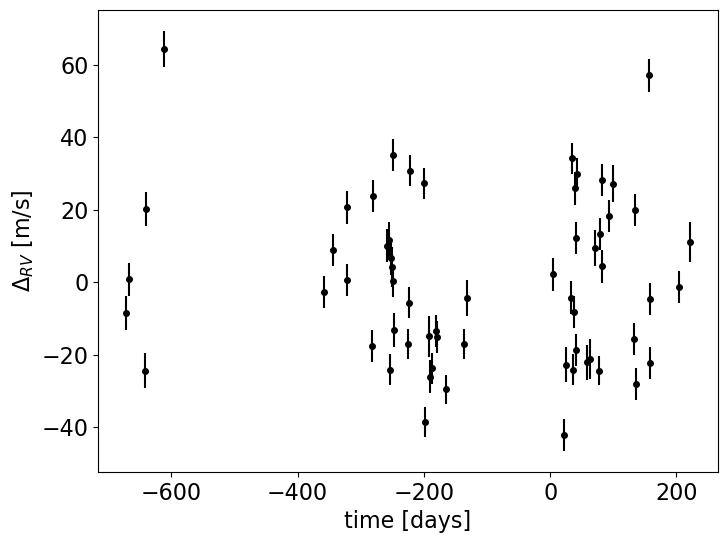

In [22]:
data = pd.read_table('./data/rvs/1199_final_rvs.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err', 'bis(km/s)': 'bis'}, inplace=True)

x_rv = np.array(data.bjd+2400000-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)


plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

In [23]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x_rv.min() + x_rv.max())

K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print(K, "m/s")

# Stellar parameters from Sousa
M_star = 1.18, 0.02
R_star = 1.45, 0.05

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print('minimum mass=', msini)

[28.38522575] m/s
minimum mass= [76.46697698] earthMass


Periodograms

In [24]:
from astropy.timeseries import LombScargle

In [25]:
# read de BIS data
ls = LombScargle(data.bjd, data.rv, data.err)
ls_bis = LombScargle(data.bjd, data.bis)

frequency, power = ls.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

frequency_bis, power_bis = ls_bis.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

probabilities = [0.1, 0.05, 0.01]
faps = ls.false_alarm_level(probabilities)  
faps_bis = ls_bis.false_alarm_level(probabilities)


In [26]:
# aliases computed in DACE
aliases = [1.374, 1.369, 0.786, 0.784]

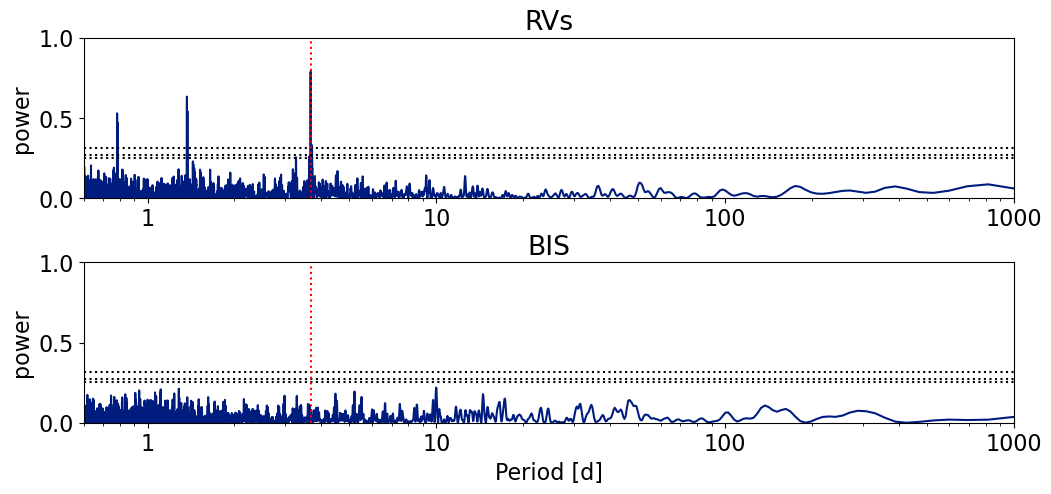

In [27]:
from matplotlib.ticker import ScalarFormatter
# plot two figures in a column
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12, 5))
axes[0].plot(1/frequency, power, label='RVs') 
axes[1].plot(1/frequency_bis, power_bis, label='BIS') 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

axes[0].set_xlabel('')
axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[1].set_xlabel('Period [d]')
axes[1].set_xlim(0.6, 1000)
axes[1].set_ylim(0, 1.0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].set_ylabel('power')
axes[1].set_ylabel('power')
axes[0].title.set_text('RVs')
axes[1].title.set_text('BIS')

# overplot the false alarm probabilities
for i, prob in enumerate(probabilities):
    axes[0].axhline(faps[i], ls=':', color='black', label='{}%'.format(prob))
    axes[1].axhline(faps_bis[i], ls=':', color='black', label='{}%'.format(prob))

# plot the 'bls_period' as a vertical line behind the plot
axes[0].axvline(bls_period, ls=':', color='red', label='bls period')
axes[1].axvline(bls_period, ls=':', color='red', label='bls period')

formatter = ScalarFormatter()
axes[0].xaxis.set_major_formatter(formatter)
axes[1].xaxis.set_major_formatter(formatter)
#plt.savefig('bisrv_periodogram_1199.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

BIS vs rvs

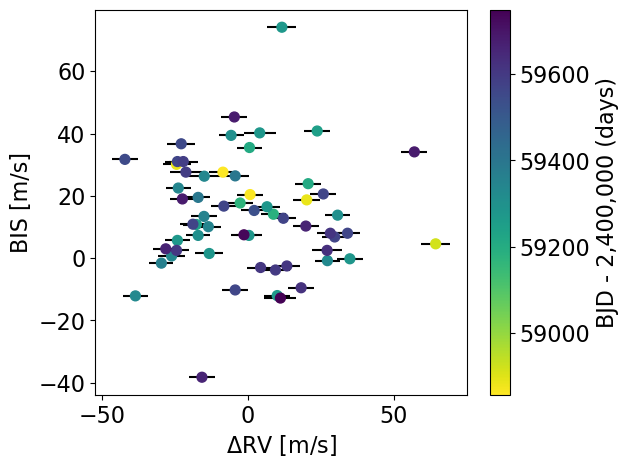

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
g = ax.scatter(y_rv, data.bis*1e3, c=data.bjd, cmap='viridis_r', s=50, zorder=10)
# add errorbars on data.rv
ax.errorbar(y_rv, data.bis*1e3, xerr=yerr_rv, fmt='none', ecolor='k', markersize=8, zorder=-10)
ax.set_xlabel("$\Delta$RV [m/s]")
ax.set_ylabel("BIS [m/s]")
fig.colorbar(g, label='BJD - 2,400,000 (days)')
#plt.savefig('bisrv_1199.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [29]:
0.5*np.log(bls_depth * 1e-3)

-2.793537993043475

In [30]:
np.log(np.median(yerr_rv))

1.4816045409242156

## Ground LCs

### KeplerCam

In [31]:
# filtros griz sloan: B y z'
# B     440nm		483.5nm	                        43.5nm
# z'	>820nm	    966.5nm	                        255.8nm	

In [32]:
data1 = pd.read_table('./data/photom/TOI1199/KEPLERCAM/TIC99869022.01_UT2021.0213_KeplerCam_B.dat', sep='\s+')
data2 = pd.read_table('./data/photom/TOI1199/KEPLERCAM/TIC99869022.01_UT2021.0413_KeplerCam_B.dat', sep='\s+')
data3 = pd.read_table('./data/photom/TOI1199/KEPLERCAM/TIC99869022.01_UT2021.0213_KeplerCam_z.dat', sep='\s+')
data4 = pd.read_table('./data/photom/TOI1199/KEPLERCAM/TIC99869022.01_UT2021.0413_KeplerCam_z.dat', sep='\s+')
data1.columns

Index(['#', 'Label', 'BJD_TDB', 'rel_flux_T1', 'rel_flux_err_T1', 'AIR',
       'JD_UTC'],
      dtype='object')

In [33]:
#puntos?
print('puntos:', len(data1)+len(data2)+len(data3)+len(data4))
# texp?
print('texp:', np.median(np.diff(data1['BJD_TDB']))*24*60*60)
texp_keplercam = None

puntos: 732
texp: 105.06239533424377


In [34]:
data1['flux'] = ((data1['rel_flux_T1']/(data1['rel_flux_T1'].median())))*1e3
data2['flux'] = ((data2['rel_flux_T1']/(data2['rel_flux_T1'].median())))*1e3
data3['flux'] = ((data3['rel_flux_T1']/(data3['rel_flux_T1'].median())))*1e3
data4['flux'] = ((data4['rel_flux_T1']/(data4['rel_flux_T1'].median())))*1e3

data1['flux_err'] = ((data1['rel_flux_err_T1']/(data1['rel_flux_T1'].median())))*1e3
data1['flux_err'] = ((data1['rel_flux_err_T1']/(data1['rel_flux_T1'].median())))*1e3
data2['flux_err'] = ((data2['rel_flux_err_T1']/(data2['rel_flux_T1'].median())))*1e3
data3['flux_err'] = ((data3['rel_flux_err_T1']/(data3['rel_flux_T1'].median())))*1e3
data4['flux_err'] = ((data4['rel_flux_err_T1']/(data4['rel_flux_T1'].median())))*1e3

data1['time'] = data1['BJD_TDB']-2457000-ref_time
data2['time'] = data2['BJD_TDB']-2457000-ref_time
data3['time'] = data3['BJD_TDB']-2457000-ref_time
data4['time'] = data4['BJD_TDB']-2457000-ref_time

In [35]:
out_mask3 = np.abs(data3.flux-data4.flux.mean())<3*data3.flux.std()
out_mask1 = np.abs(data1.flux-data2.flux.mean())<3*data1.flux.std()
data3 = data3[out_mask3]
data1 = data1[out_mask1]

k_mask1 = bls.transit_mask(data1['time'], bls_period, 0.2, bls_t0)
k_mask2 = bls.transit_mask(data2['time'], bls_period, 0.2, bls_t0)
k_mask3 = bls.transit_mask(data3['time'], bls_period, 0.2, bls_t0)
k_mask4 = bls.transit_mask(data4['time'], bls_period, 0.2, bls_t0)

data1 = data1[k_mask1]
data2 = data2[k_mask2]
data3 = data3[k_mask3]
data4 = data4[k_mask4]

In [36]:
#puntos?
print('puntos:', len(data1)+len(data2)+len(data3)+len(data4))

puntos: 635


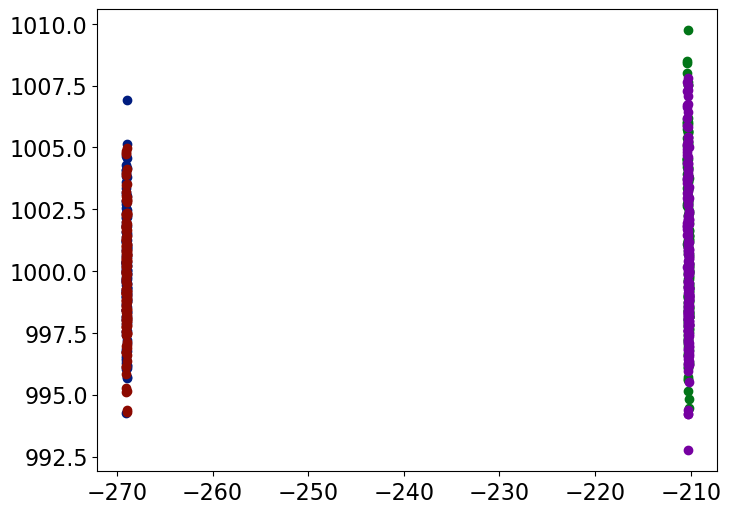

In [37]:
# Lest plot them together
plt.plot(data1['time'], data1['flux'], 'o', label='2021.0213_KeplerCam_B')
plt.plot(data2['time'], data2['flux'], 'o', label='2021.0413_KeplerCam_B')
plt.plot(data3['time'], data3['flux'], 'o', label='2021.0213_KeplerCam_z')
plt.plot(data4['time'], data4['flux'], 'o', label='2021.0413_KeplerCam_z')
#plt.xlim(-211, -210)
#plt.xlim(-269.2,-268.5)
plt.show()

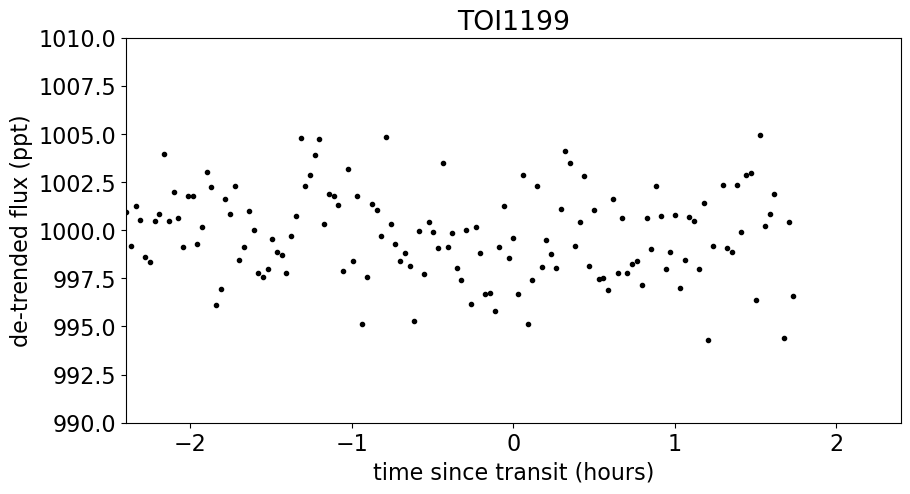

In [38]:
# Plot the folded data, con los parametros del BLS
data1_fold = (data1['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data2_fold = (data2['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data3_fold = (data3['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data4_fold = (data4['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

plt.figure(figsize=(10, 5))
#plt.plot(data1_fold*24, data1['flux'], ".k", label="data1", zorder=-1000)
#plt.plot(data2_fold*24, data2['flux'], ".k", label="data2", zorder=-1000)
plt.plot(data3_fold*24, data3['flux'], ".k", label="data3", zorder=-1000)
#plt.plot(data4_fold*24, data4['flux'], ".k", label="data4", zorder=-1000)

plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.ylim(990,1010)
plt.title("TOI1199")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

In [39]:
# ajustemos un pol grado 2 a los datos oot
# mascaras para sacar los datos en transito
oot_mask1 = bls.transit_mask(data1['time'], spoc_period, spoc_duration, bls_t0)
oot_mask2 = bls.transit_mask(data2['time'], spoc_period, spoc_duration, bls_t0)
oot_mask3 = bls.transit_mask(data3['time'], spoc_period, spoc_duration, bls_t0)
oot_mask4 = bls.transit_mask(data4['time'], spoc_period, spoc_duration, bls_t0)

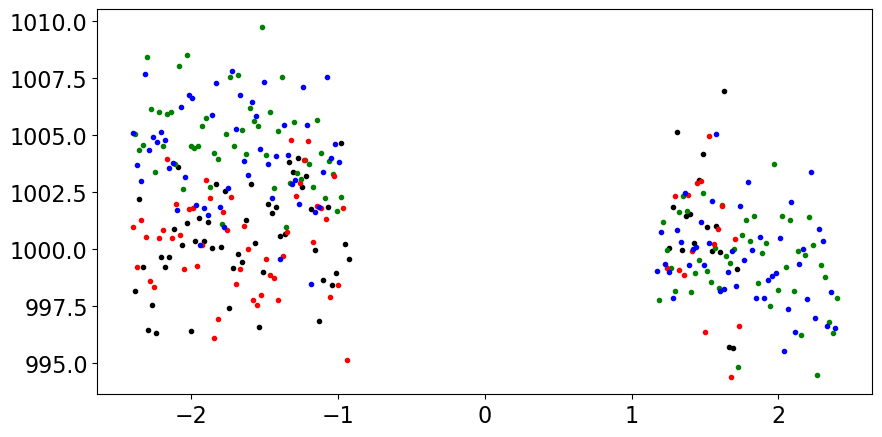

In [40]:
# checking the oot mask
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], ".k", label="data1", zorder=-1000)
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2], ".g", label="data2", zorder=-1000)
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3], ".r", label="data3", zorder=-1000)
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4], ".b", label="data4", zorder=-1000)

In [41]:
# fitemos un pol grado 2 a los datos oot
# separando por bandas y fecha del transito
z_B1 = np.polyfit((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], 2) 
z_B2 = np.polyfit((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2], 2)
z_z1 = np.polyfit((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3], 2)
z_z2 = np.polyfit((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4], 2)

def pol_B1(x):
    return np.asarray(z_B1[0]*x**2 + z_B1[1]*x + z_B1[2])
def pol_B2(x):
    return np.asarray(z_B2[0]*x**2 + z_B2[1]*x + z_B2[2])
def pol_z1(x):
    return np.asarray(z_z1[0]*x**2 + z_z1[1]*x + z_z1[2])
def pol_z2(x):
    return np.asarray(z_z2[0]*x**2 + z_z2[1]*x + z_z2[2])

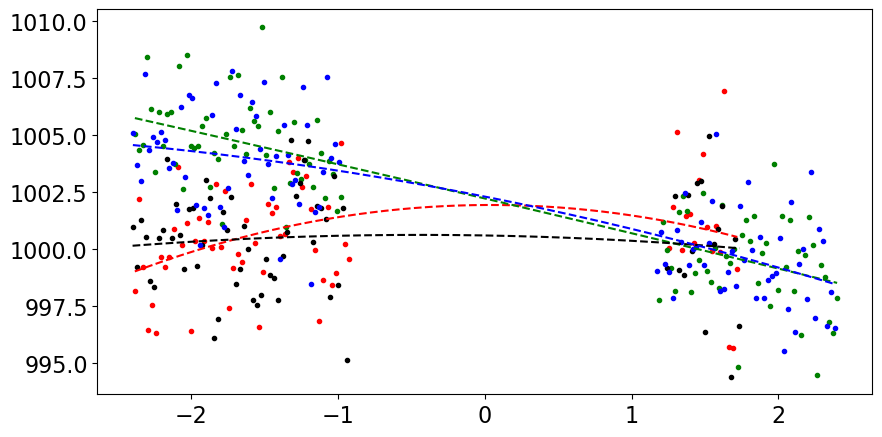

In [42]:
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], ".r", label="data1", zorder=-1000)
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2], ".g", label="data2", zorder=-1000)
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3], ".k", label="data3", zorder=-1000)
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4], ".b", label="data4", zorder=-1000)
x_plot_B1 = np.linspace(np.min((data1_fold*24)[~oot_mask1]), np.max((data1_fold*24)[~oot_mask1]), 1000) 
x_plot_B2 = np.linspace(np.min((data2_fold*24)[~oot_mask2]), np.max((data2_fold*24)[~oot_mask2]), 1000)
x_plot_z1 = np.linspace(np.min((data3_fold*24)[~oot_mask3]), np.max((data3_fold*24)[~oot_mask3]), 1000)
x_plot_z2 = np.linspace(np.min((data4_fold*24)[~oot_mask4]), np.max((data4_fold*24)[~oot_mask4]), 1000)
plt.plot(x_plot_B1, pol_B1(x_plot_B1), color="r", linestyle="--")
plt.plot(x_plot_B2, pol_B2(x_plot_B2), color="g", linestyle="--")
plt.plot(x_plot_z1, pol_z1(x_plot_z1), color="k", linestyle="--")
plt.plot(x_plot_z2, pol_z2(x_plot_z2), color="b", linestyle="--")

#plt.savefig('ajuste_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')

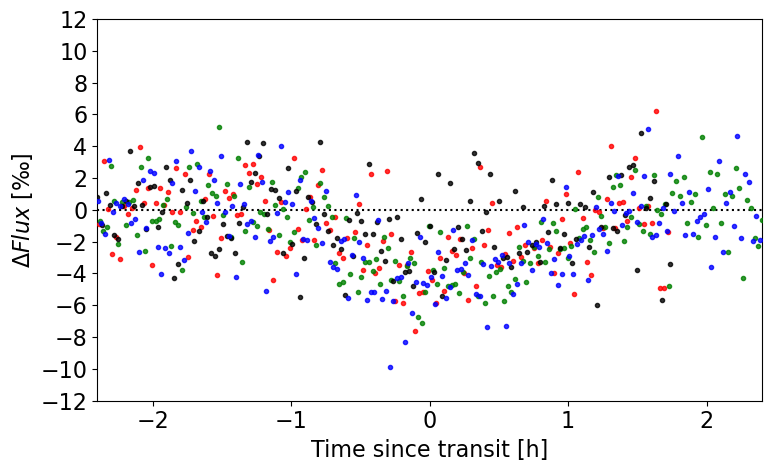

In [43]:
#replot dividing by polynomial
plt.figure(figsize=(8, 5))
# Plot the data
plt.plot(data1_fold*24, (data1['flux']/pol_B1(data1_fold*24)-1)*1e3, 'o', ms=3, color='r', zorder=1000, alpha=0.8)
plt.plot(data2_fold*24, (data2['flux']/pol_B2(data2_fold*24)-1)*1e3, 'o', ms=3, color='g', zorder=1000, alpha=0.8)
plt.plot(data3_fold*24, (data3['flux']/pol_z1(data3_fold*24)-1)*1e3, 'o', ms=3, color='k', zorder=1000, alpha=0.8)
plt.plot(data4_fold*24, (data4['flux']/pol_z2(data4_fold*24)-1)*1e3, 'o', ms=3, color='b', zorder=1000, alpha=0.8)
#plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.yticks([-12,-10,-8, -6, -4, -2,0,2,4,6,8,10,12])
plt.xlim(-0.10*24, 0.10*24)
# horizontal line at 0
plt.axhline(0, color="k", linestyle=":")
plt.ylim(-12, 12)
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()


In [44]:
# datos de keplercam finales
y_conc_B = np.concatenate(((data1['flux']/pol_B1(data1_fold*24)-1)*1e3, 
                          (data2['flux']/pol_B2(data2_fold*24)-1)*1e3), axis=None)
y_conc_z = np.concatenate(((data3['flux']/pol_z1(data3_fold*24)-1)*1e3, 
                          (data4['flux']/pol_z2(data4_fold*24)-1)*1e3), axis=None)
yerr_conc_B = np.concatenate((data1['flux_err'], data2['flux_err']), axis=None)
yerr_conc_z = np.concatenate((data3['flux_err'], data4['flux_err']), axis=None)

x_keplercam_B = np.concatenate((data1['time'], data2['time']), axis=None)
x_keplercam_z = np.concatenate((data3['time'], data4['time']), axis=None)
y_keplercam_B = y_conc_B
yerr_keplercam_B = yerr_conc_B
y_keplercam_z = y_conc_z
yerr_keplercam_z = yerr_conc_z

In [45]:
# new detrending ?

In [46]:
data1_ = pd.read_table('data/photom/TOI1199/KEPLERCAM/TIC99869022.01_UT2021.0213_KeplerCam_B.tbl', sep='\s+')
data2_ = pd.read_table('data/photom/TOI1199/KEPLERCAM/TIC99869022.01_UT2021.0413_KeplerCam_B_measurements.tbl', sep='\s+')
data3_ = pd.read_table('data/photom/TOI1199/KEPLERCAM/TIC99869022.01_UT2021.0213_KeplerCam_z.tbl', sep='\s+')
data4_ = pd.read_table('data/photom/TOI1199/KEPLERCAM/TIC99869022.01_UT2021.0413_KeplerCam_z_measurements.tbl', sep='\s+')

In [47]:
data1_['flux'] = data1_['rel_flux_T1_dn']*1e3-1e3
data2_['flux'] = data2_['rel_flux_T1_dn']*1e3-1e3
data3_['flux'] = data3_['rel_flux_T1_dn']*1e3-1e3
data4_['flux'] = data4_['rel_flux_T1_dn']*1e3-1e3

data1_['flux_err'] = data1_['rel_flux_err_T1_dn']*1e3
data2_['flux_err'] = data2_['rel_flux_err_T1_dn']*1e3
data3_['flux_err'] = data3_['rel_flux_err_T1_dn']*1e3
data4_['flux_err'] = data4_['rel_flux_err_T1_dn']*1e3

data1_['time'] = data1_['BJD_TDB']-2457000-ref_time
data2_['time'] = data2_['BJD_TDB']-2457000-ref_time
data3_['time'] = data3_['BJD_TDB']-2457000-ref_time
data4_['time'] = data4_['BJD_TDB']-2457000-ref_time

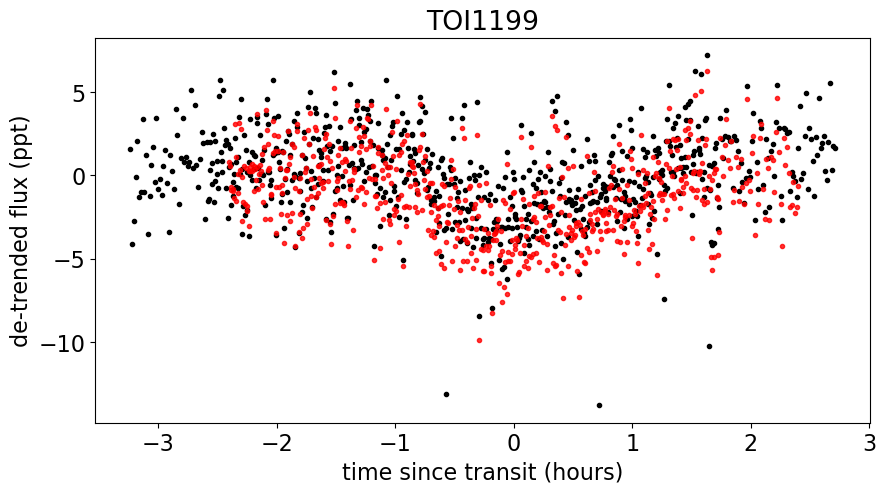

In [48]:
# Plot the folded data, con los parametros del BLS
data1_fold_ = (data1_['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data2_fold_ = (data2_['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data3_fold_ = (data3_['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data4_fold_ = (data4_['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

plt.figure(figsize=(10, 5))
plt.plot(data1_fold_*24, data1_['flux'], ".k", label="data1", zorder=-1000)
plt.plot(data2_fold_*24, data2_['flux'], ".k", label="data2", zorder=-1000)
plt.plot(data3_fold_*24, data3_['flux'], ".k", label="data3", zorder=-1000)
plt.plot(data4_fold_*24, data4_['flux'], ".k", label="data4", zorder=-1000)
plt.plot(data1_fold*24, (data1['flux']/pol_B1(data1_fold*24)-1)*1e3, 'o', ms=3, color='r', zorder=1000, alpha=0.8)
plt.plot(data2_fold*24, (data2['flux']/pol_B2(data2_fold*24)-1)*1e3, 'o', ms=3, color='r', zorder=1000, alpha=0.8)
plt.plot(data3_fold*24, (data3['flux']/pol_z1(data3_fold*24)-1)*1e3, 'o', ms=3, color='r', zorder=1000, alpha=0.8)
plt.plot(data4_fold*24, (data4['flux']/pol_z2(data4_fold*24)-1)*1e3, 'o', ms=3, color='r', zorder=1000, alpha=0.8)
plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.title("TOI1199")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

### MuSCAT2

In [49]:
# filtros griz sloan: g', r', i', z'
#       Wavelength	Effective Central Wavelength	FWHM	
# g'	401-550nm	475.4nm	                        138.7nm	
# r'	562-695nm	620.4nm	                        124.0nm	
# i'	695-844nm	769.8nm	                        130.3nm	
# z'	>820nm	    900.0nm	                        100.0nm

In [50]:
data5 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427_zs_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')
data6 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427._g_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')
data7 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427._i_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')
data8 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427._r_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')


In [51]:
print(np.mean(data7['flux']-1))
print(np.mean(data7['flux']/np.median(data7['flux'])-1))

-0.003825118812903224
5.0627396101687584e-05


In [52]:
# Convert time to the same reference time as tess and flux to ppt
data5['bjd'] = data5['bjd']-2457000-ref_time
data6['bjd'] = data6['bjd']-2457000-ref_time
data7['bjd'] = data7['bjd']-2457000-ref_time
data8['bjd'] = data8['bjd']-2457000-ref_time
data5['flux'] = np.ascontiguousarray(1e3 * (data5['flux'] - 1.0), dtype=np.float64) 
data6['flux'] = np.ascontiguousarray(1e3 * (data6['flux'] - 1.0), dtype=np.float64)
data7['flux'] = np.ascontiguousarray(1e3 * (data7['flux'] - 1.0), dtype=np.float64)
data8['flux'] = np.ascontiguousarray(1e3 * (data8['flux'] - 1.0), dtype=np.float64)
data5['flux_err'] = np.ascontiguousarray(1e3 * (data5['flux_err']), dtype=np.float64) 
data6['flux_err'] = np.ascontiguousarray(1e3 * (data6['flux_err']), dtype=np.float64)
data7['flux_err'] = np.ascontiguousarray(1e3 * (data7['flux_err']), dtype=np.float64)
data8['flux_err'] = np.ascontiguousarray(1e3 * (data8['flux_err']), dtype=np.float64)

In [53]:
# Texp?
print(np.median(np.diff(data8['bjd']))*24*60*60)
texp_muscat = None

11.015751957893372


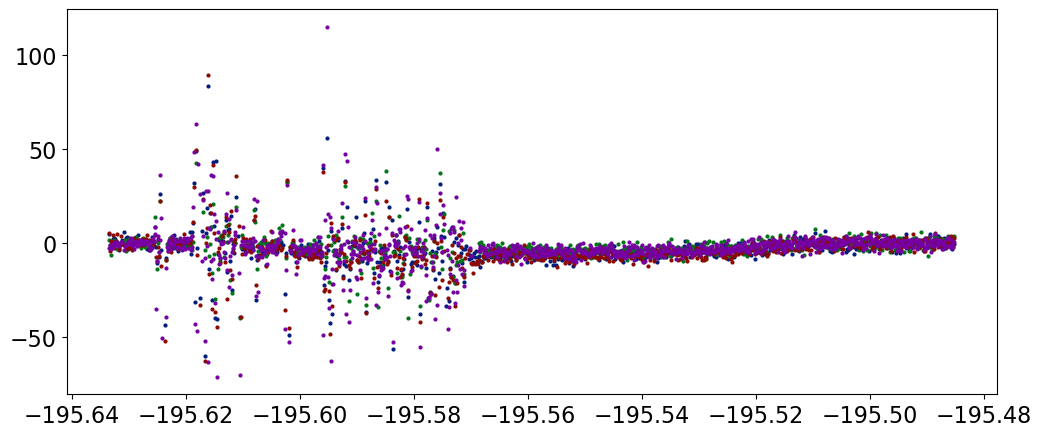

In [54]:
plt.figure(figsize=(12, 5))
plt.plot(data5.bjd, data5.flux, 'o', label='z', ms=2)
plt.plot(data6.bjd, data6.flux, 'o', label='z', ms=2)
plt.plot(data7.bjd, data7.flux, 'o', label='z', ms=2)
plt.plot(data8.bjd, data8.flux, 'o', label='z', ms=2)
plt.show()

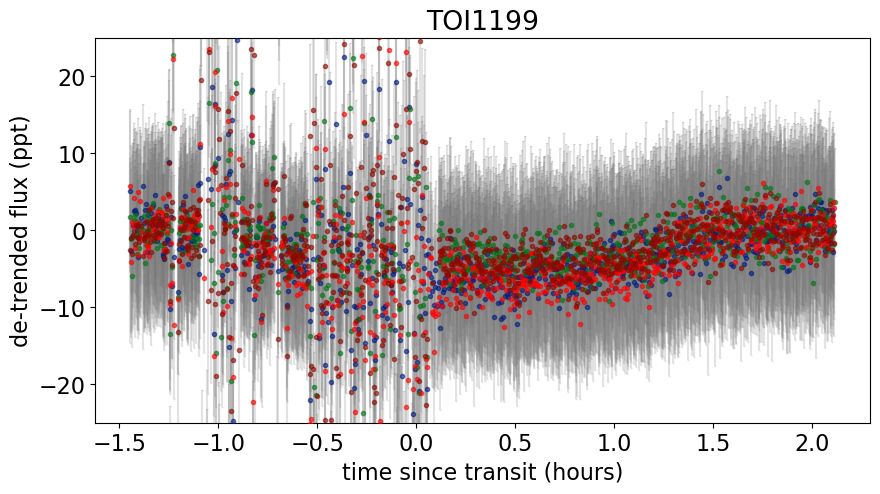

In [55]:
# Plot the folded data, con los parametros del BLS
data5_fold = (data5['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data6_fold = (data6['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data7_fold = (data7['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data8_fold = (data8['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

muscat_time = pd.concat([data5_fold, data6_fold, data7_fold, data8_fold], ignore_index=True)
# datos finales muscat
x_muscat_zs_ = np.ascontiguousarray(data5['bjd'], dtype=np.float64)
x_muscat_g_ = np.ascontiguousarray(data6['bjd'], dtype=np.float64)
x_muscat_i_ = np.ascontiguousarray(data7['bjd'], dtype=np.float64)
x_muscat_r_ = np.ascontiguousarray(data8['bjd'], dtype=np.float64)
y_muscat_zs_ = np.ascontiguousarray(data5['flux'], dtype=np.float64)
y_muscat_g_ = np.ascontiguousarray(data6['flux'], dtype=np.float64)
y_muscat_i_ = np.ascontiguousarray(data7['flux'], dtype=np.float64)
y_muscat_r_ = np.ascontiguousarray(data8['flux'], dtype=np.float64)
yerr_muscat_zs_ = np.ascontiguousarray(data5['flux_err'], dtype=np.float64)
yerr_muscat_g_ = np.ascontiguousarray(data6['flux_err'], dtype=np.float64)
yerr_muscat_i_ = np.ascontiguousarray(data7['flux_err'], dtype=np.float64)
yerr_muscat_r_ = np.ascontiguousarray(data8['flux_err'], dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(data5_fold*24, y_muscat_zs_, '.', label='Muscat2_zs', alpha=0.6, zorder=100)
plt.errorbar(data5_fold*24, y_muscat_zs_, yerr=yerr_muscat_zs_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data6_fold*24, y_muscat_g_, '.', label='Muscat2_g', alpha=0.6, zorder=100)
plt.errorbar(data6_fold*24, y_muscat_g_, yerr=yerr_muscat_g_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data7_fold*24, y_muscat_i_, '.', color='red', label='Muscat2_i', alpha=0.6, zorder=100)
plt.errorbar(data7_fold*24, y_muscat_i_, yerr=yerr_muscat_i_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data8_fold*24, y_muscat_r_, '.', label='Muscat2_r', alpha=0.6, zorder=100)
plt.errorbar(data8_fold*24, y_muscat_r_, yerr=yerr_muscat_r_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)

plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
#plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-25,25)
plt.title("TOI1199")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

In [56]:
# mask the first half of the transit
x_muscat_zs = x_muscat_zs_[data5_fold*24>0.10]
x_muscat_g = x_muscat_g_[data6_fold*24>0.10]
x_muscat_i = x_muscat_i_[data7_fold*24>0.10]
x_muscat_r = x_muscat_r_[data8_fold*24>0.10]
y_muscat_zs = y_muscat_zs_[data5_fold*24>0.10]
y_muscat_g = y_muscat_g_[data6_fold*24>0.10]
y_muscat_i = y_muscat_i_[data7_fold*24>0.10]
y_muscat_r = y_muscat_r_[data8_fold*24>0.10]
yerr_muscat_zs = yerr_muscat_zs_[data5_fold*24>0.10]
yerr_muscat_g = yerr_muscat_g_[data6_fold*24>0.10]
yerr_muscat_i = yerr_muscat_i_[data7_fold*24>0.10]
yerr_muscat_r = yerr_muscat_r_[data8_fold*24>0.10]

print(len(x_muscat_zs), len(y_muscat_zs), len(yerr_muscat_zs))
print(len(x_muscat_g), len(y_muscat_g), len(yerr_muscat_g))
print(len(x_muscat_i), len(y_muscat_i), len(yerr_muscat_i))
print(len(x_muscat_r), len(y_muscat_r), len(yerr_muscat_r))


453 453 453
445 445 445
452 452 452
654 654 654


# LC dataset

In [57]:
from collections import OrderedDict

# datasets = OrderedDict(
#     [
#         ("tess_2min", [x, y, yerr, texp]),
#         ("tess_30min", [xlong, ylong, yerrlong, texp_long]),
#         ("keplercam_B", [x_keplercam_B, y_keplercam_B, yerr_keplercam_B, texp_keplercam]),
#         ('muscat_g', [x_muscat_g, y_muscat_g, yerr_muscat_g, texp_muscat]),
#         ('muscat_r', [x_muscat_r, y_muscat_r, yerr_muscat_r, texp_muscat]),
#         ('muscat_i', [x_muscat_i, y_muscat_i, yerr_muscat_i, texp_muscat]),
#         ("keplercam_z", [x_keplercam_z, y_keplercam_z, yerr_keplercam_z, texp_keplercam]),
#         ('muscat_zs', [x_muscat_zs, y_muscat_zs, yerr_muscat_zs, texp_muscat]),
#     ]
# )
datasets = OrderedDict(
    [
        ("tess_2min", [x, y, yerr, texp]),
        ("tess_30min", [xlong, ylong, yerrlong, texp_long]),
        ("keplercam_B", [x_keplercam_B, y_keplercam_B, yerr_keplercam_B, texp_keplercam]),
        ("keplercam_z", [x_keplercam_z, y_keplercam_z, yerr_keplercam_z, texp_keplercam]),
    ]
)

In [58]:
for n, (name, (x_, y_, yerr_, texp_)) in enumerate(datasets.items()):
    print(n, name, len(x_), len(y_), len(yerr_), type(x_), type(y_), type(yerr_))

0 tess_2min 1894 1894 1894 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
1 tess_30min 96 96 96 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
2 keplercam_B 317 317 317 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
3 keplercam_z 318 318 318 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


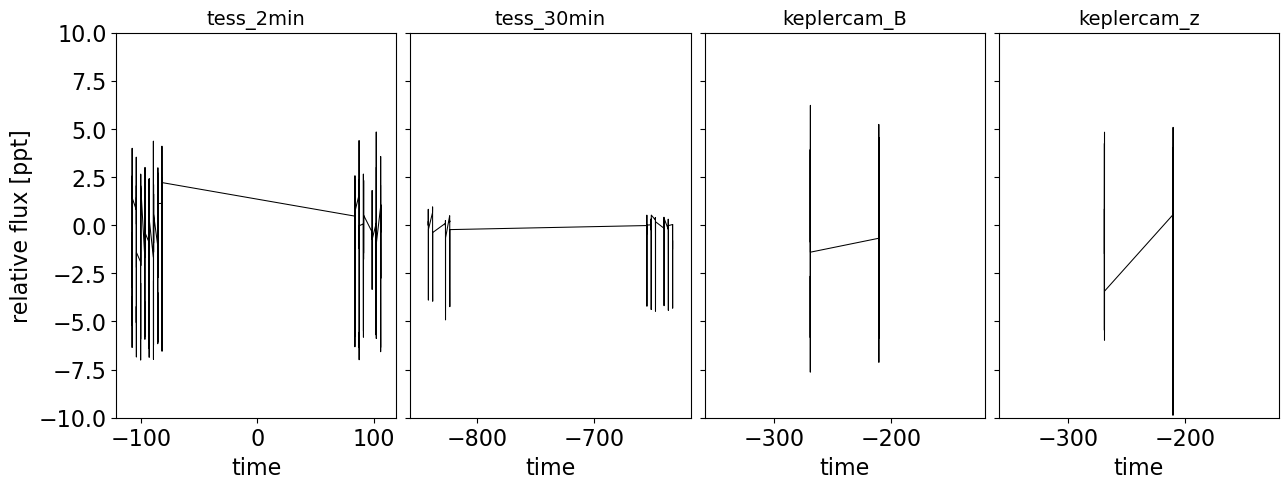

In [59]:
fig, axes = plt.subplots(1, len(datasets), sharey=True, figsize=(15, 5))

for i, (name, (t, y, _, _)) in enumerate(datasets.items()):
    ax = axes[i]
    ax.plot(t, y, "k", lw=0.75, label=name)
    ax.set_xlabel("time")
    ax.set_title(name, fontsize=14)

    x_mid = 0.5 * (t.min() + t.max())
    ax.set_xlim(x_mid - 120, x_mid + 120)
axes[0].set_ylim(-10, 10)
fig.subplots_adjust(wspace=0.05)
_ = axes[0].set_ylabel("relative flux [ppt]")

In [60]:
K_est = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print(K_est, "m/s")

[28.38522575] m/s


In [61]:
0.5*np.log(spoc_depth * 1e-3)

-2.7199404654349117

In [62]:
np.log((spoc_depth * 1e-3)**(1/2))

-2.7199404654349117

# Joint model

In [63]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 500)

for i in range(10):
    with pm.Model() as model:
        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        # b = pmx.UnitUniform("b")
        log_ror = pm.Normal("log_ror", mu=0.5*np.log(spoc_depth * 1e-3), sd=1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        b = xo.ImpactParameter('b', ror)

        logK = pm.Normal("logK", mu=np.log(K_est.item()), sd=2.0)
        K = pm.Deterministic("K", tt.exp(logK))
        #m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        # comentar las proximas tres lineas para versión con e=0 fixed
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=1)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Loop over the instruments
        parameters = dict()
        lc_models = dict()
        transit_obs = dict()
        lc_pred = dict()
        
        # The light curve model
        def lc_model(mean, star, r_pl, texp, t):
            return tt.sum(1e3*star.get_light_curve(orbit=orbit, r=r_pl, t=t, texp=texp), axis=-1) + mean
        
        for n, (name, (x_, y_, yerr_, texp_)) in enumerate(datasets.items()):
            # We define the per-instrument parameters in a submodel so that we
            # don't have to prefix the names manually
            
            with pm.Model(name=name, model=model):
                # The flux zero point
                mean = pm.Normal("mean", mu=0.0, sd=5.0)
                # The limb darkening
                # both tess datasets should share the same limb darkening coefficients
                if "tess_30min" in name:
                    star = xo.LimbDarkLightCurve(u_star)
                else:
                    u_star = xo.QuadLimbDark("u_star")
                    star = xo.LimbDarkLightCurve(u_star)

                # Transit jitter
                logs = pm.Normal("logs", mu=np.log(np.median(yerr_)), sd=1)
                
                # Keep track of the parameters for optimization
                parameters[name] = [mean, u_star, logs]

            #lc_model = partial(lc_model, mean, star, ror, texp)
            lc_models[name] = lc_model(mean, star, r_pl, texp_, x_)

            # The likelihood for the light curve
            err_lc = tt.sqrt(yerr_**2 + tt.exp(2*logs)) 
            transit_obs = pm.Normal(f"{name}_obs", mu=lc_models[name], sd=err_lc, observed=y_) 

            # Compute and save the phased light curve models
            pm.Deterministic(f"{name}_lc_pred", tt.sum(star.get_light_curve(orbit=orbit, r=r_pl, t=t0+phase_lc, texp=texp_)*1e3, axis=-1))


        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Optimize the model
        map_soln = model.test_point
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name])
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name] + [logK, ecs, b, log_period])
            map_soln = pmx.optimize(map_soln, parameters[name] + [log_sigma_rv, trend])
        map_soln = pmx.optimize(map_soln)

        extras = dict()
        for name in datasets:
            extras[name] = pmx.eval_in_model(lc_models[name], map_soln)

        # Do some sigma clipping
        num = dict((name, len(datasets[name][0])) for name in datasets)
        clipped = dict()
        masks = dict()
        for name in datasets:
            mdl = pmx.eval_in_model(lc_models[name], map_soln)
            resid = datasets[name][1] - mdl
            sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
            masks[name] = np.abs(resid - np.median(resid)) < 7 * sigma
            clipped[name] = num[name] - masks[name].sum()
            print(f"Sigma clipped {clipped[name]} {name} light curve points")

        if all(c < 10 for c in clipped.values()):
            break

        else:
            for name in datasets:
                datasets[name][0] = datasets[name][0][masks[name]]
                datasets[name][1] = datasets[name][1][masks[name]]
                datasets[name][2] = datasets[name][2][masks[name]]

message: Optimization terminated successfully.
logp: -7396.100117704558 -> -6736.33252501671


message: Optimization terminated successfully.
logp: -6736.33252501671 -> -6000.448238021886


message: Optimization terminated successfully.
logp: -6000.448238021886 -> -5834.432984339963


message: Optimization terminated successfully.
logp: -5834.432984339963 -> -5694.618113884061


message: Desired error not necessarily achieved due to precision loss.
logp: -5694.618113884061 -> -5308.752069735506


message: Desired error not necessarily achieved due to precision loss.
logp: -5308.752069735506 -> -5275.752661680255


message: Desired error not necessarily achieved due to precision loss.
logp: -5275.752661680255 -> -5164.794378390301


message: Desired error not necessarily achieved due to precision loss.
logp: -5164.794378390301 -> -5158.136223215675


message: Desired error not necessarily achieved due to precision loss.
logp: -5158.136223215675 -> -5088.572417768967


message: Desired error not necessarily achieved due to precision loss.
logp: -5088.572417768968 -> -5083.032721173835


message: Desired error not necessarily achieved due to precision loss.
logp: -5083.032721173834 -> -5043.034142133536


message: Optimization terminated successfully.
logp: -5043.034142133537 -> -5042.908586557944


message: Desired error not necessarily achieved due to precision loss.
logp: -5042.908586557941 -> -4821.388577739258


Sigma clipped 0 tess_2min light curve points
Sigma clipped 1 tess_30min light curve points
Sigma clipped 0 keplercam_B light curve points
Sigma clipped 0 keplercam_z light curve points


In [219]:
model.free_RVs

[m_star_interval__ ~ TransformedDistribution,
 r_star_interval__ ~ TransformedDistribution,
 t0 ~ Normal,
 log_period ~ Normal,
 log_ror ~ Normal,
 b_impact__ ~ TransformedDistribution,
 logK ~ Normal,
 ecs_unitdisk+interval__ ~ TransformedDistribution,
 log_sigma_rv ~ Normal,
 trend ~ Normal,
 tess_2min_mean ~ Normal,
 tess_2min_u_star_quadlimbdark__ ~ TransformedDistribution,
 tess_2min_logs ~ Normal,
 tess_30min_mean ~ Normal,
 tess_30min_logs ~ Normal,
 keplercam_B_mean ~ Normal,
 keplercam_B_u_star_quadlimbdark__ ~ TransformedDistribution,
 keplercam_B_logs ~ Normal,
 keplercam_z_mean ~ Normal,
 keplercam_z_u_star_quadlimbdark__ ~ TransformedDistribution,
 keplercam_z_logs ~ Normal]

MAP rv model

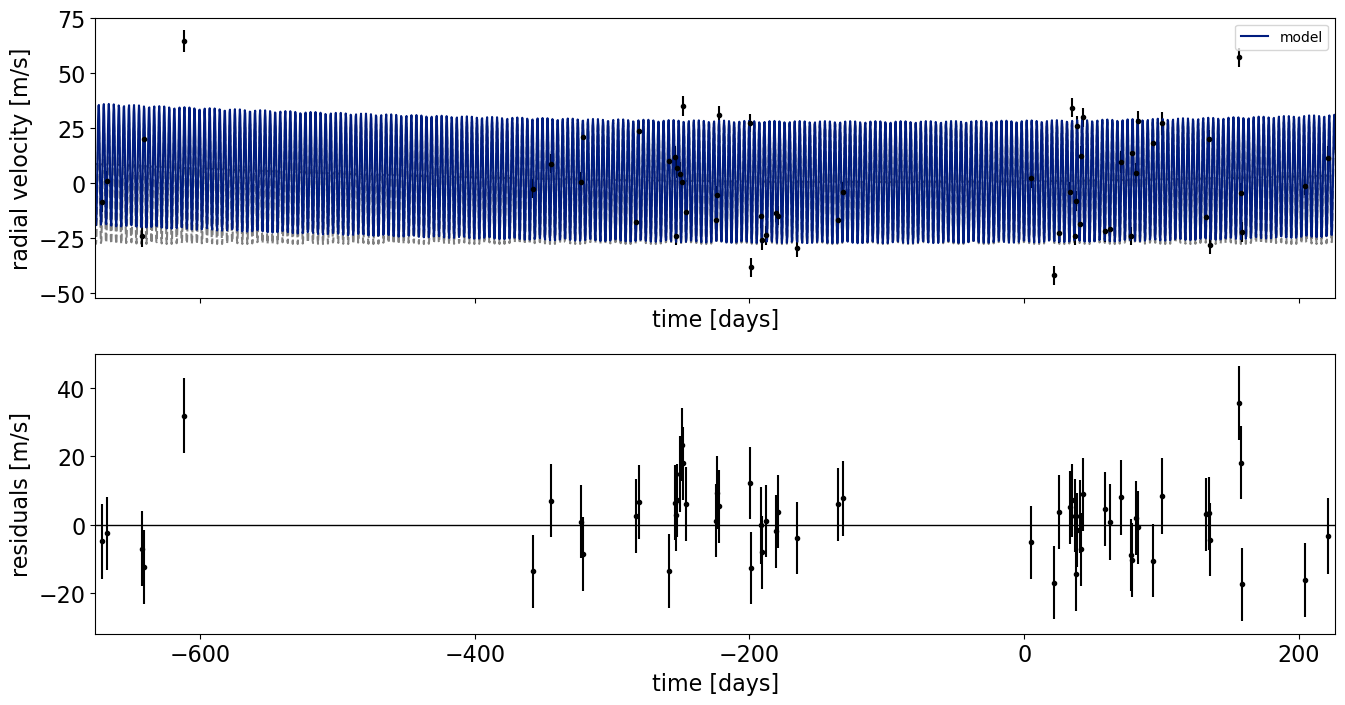

In [64]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln)

MAP LCs models

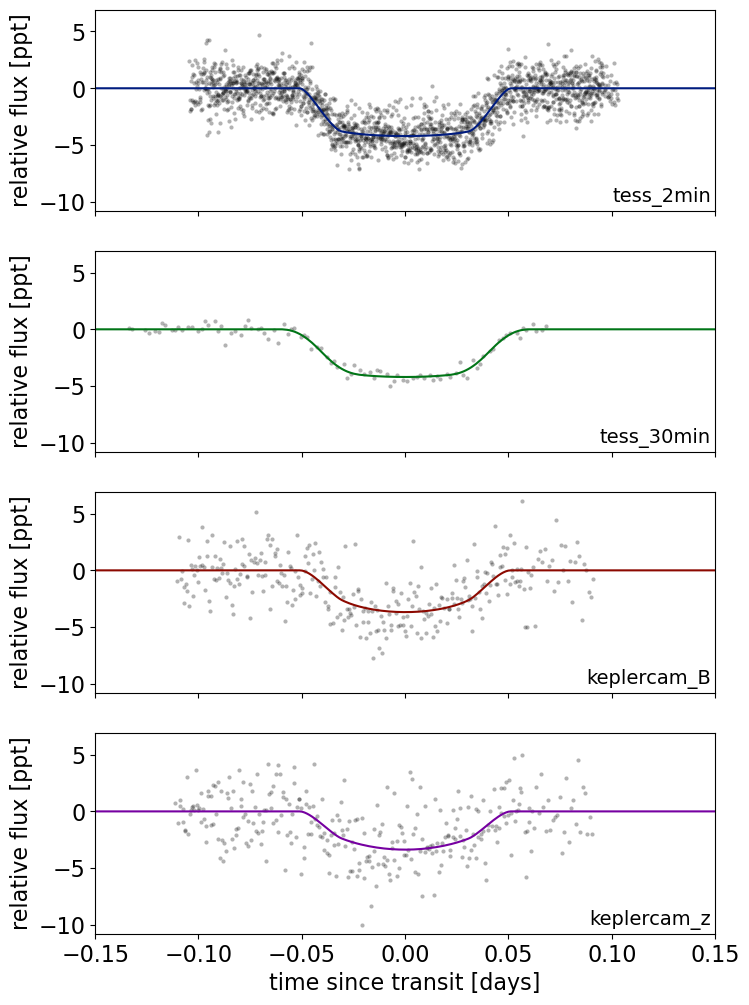

In [65]:
fig, axes = plt.subplots(len(datasets), sharex=True, sharey=True, figsize=(8, 12))

for n, name in enumerate(datasets):
    ax = axes[n]

    x, y = datasets[name][:2]

    period = map_soln["period"]
    folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
    m = np.abs(folded) < 0.2
    ax.plot(
        folded[m],
        (y  - map_soln[f"{name}_mean"])[m],
        ".k",
        alpha=0.3,
        mec="none",
    )
    ax.plot(
        phase_lc, map_soln[name+'_lc_pred'] , f"C{n}", label=name
    )

    ax.annotate(
        name,
        xy=(1, 0),
        xycoords="axes fraction",
        va="bottom",
        ha="right",
        xytext=(-3, 3),
        textcoords="offset points",
        fontsize=14,
    )

axes[-1].set_xlim(-0.15, 0.15)
axes[-1].set_xlabel("time since transit [days]")
for ax in axes:
    ax.set_ylabel("relative flux [ppt]")

#plt.savefig('lcs_fits.png', dpi=200, bbox_inches='tight')

In [66]:
# pm.model_to_graphviz(model)

# Sampling

In [67]:
with model:
    trace = pmx.sample(
        tune=4000, #1500,
        draws=4000, #1000,
        start=map_soln,
        cores=2, #4
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000],
        init="adapt_full",
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [keplercam_z_logs, keplercam_z_u_star, keplercam_z_mean, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean, tess_30min_logs, tess_30min_mean, tess_2min_logs, tess_2min_u_star, tess_2min_mean, trend, log_sigma_rv, ecs, logK, b, log_ror, log_period, t0, r_star, m_star]
NUTS: [keplercam_z_logs, keplercam_z_u_star, keplercam_z_mean, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean, tess_30min_logs, tess_30min_mean, tess_2min_logs, tess_2min_u_star, tess_2min_mean, trend, log_sigma_rv, ecs, logK, b, log_ror, log_period, t0, r_star, m_star]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 1769 seconds.


In [68]:
import arviz as az
# version con e libre
az.to_netcdf(trace, 'trace.toi1199_nomuscat.save')
#trace = az.from_netcdf('trace.toi1199_glcs_1radio_conK.save')

# version con e=0 fixed
# az.to_netcdf(trace, 'trace.toi1199_noecc.save')
# trace = az.from_netcdf('trace.toi1199_noecc.save')

'trace.toi1199_nomuscat.save'

In [69]:
#trace.posterior.data_vars
# print only the names
for n, var in enumerate(trace.posterior.data_vars):
    if n<15:
        print(n, var)


0 t0
1 log_period
2 log_ror
3 logK
4 log_sigma_rv
5 trend
6 tess_2min_mean
7 tess_2min_logs
8 tess_30min_mean
9 tess_30min_logs
10 keplercam_B_mean
11 keplercam_B_logs
12 keplercam_z_mean
13 keplercam_z_logs
14 m_star


Summary stats

In [70]:
summary = az.summary(trace, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.94, round_to=6,
           var_names=[
               't0',
               'logK',
               'log_period',
               'log_ror',
               'log_sigma_rv',
               'trend',
               'tess_2min_mean',
               'tess_2min_logs',
               'tess_30min_mean',
               'tess_30min_logs',
               'keplercam_B_mean',
               'keplercam_B_logs',
               'keplercam_z_mean',
               'keplercam_z_logs',
               'm_star',
               'r_star',
               'ror',
               'r_pl',
               'b',
               'K',
               'period',
               'ecs',
               'ecc',
               'omega',
               'tess_2min_u_star',
               'keplercam_B_u_star',
               'keplercam_z_u_star',
           ])

In [71]:
print(summary.ess_bulk.mean())
print(summary.ess_tail.mean())

7865.182943454545
5390.366176090909


In [72]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,-107.449854,0.000373,-107.450577,-107.449172,0.000004,0.000003,9870.028675,5545.942925,1.000251,-107.449849,0.000372
logK,3.312211,0.076398,3.172385,3.458629,0.000803,0.000568,9495.121455,5353.100066,1.000084,3.315839,0.076393
log_period,1.300590,0.000001,1.300588,1.300592,0.000000,0.000000,10812.450882,6172.469106,1.000462,1.300590,0.000001
log_ror,-2.710926,0.017386,-2.740595,-2.676654,0.000273,0.000193,4186.798410,4040.718448,1.000120,-2.712696,0.017385
log_sigma_rv,2.322413,0.112842,2.108797,2.534012,0.001150,0.000819,9732.734036,6023.392689,1.000819,2.321333,0.112835
trend[0],0.000028,0.000019,-0.000008,0.000064,0.000000,0.000000,10349.348205,6700.060688,1.000064,0.000028,0.000019
trend[1],-0.005915,0.006223,-0.017677,0.005769,0.000061,0.000056,10537.324502,5942.396883,0.999940,-0.005989,0.006223
trend[2],0.627672,0.912576,-1.089312,2.351571,0.008491,0.008440,11588.866587,6055.668632,1.000023,0.639160,0.912519
tess_2min_mean,0.136762,0.040148,0.061665,0.210768,0.000373,0.000278,11555.812600,5855.523581,1.000124,0.136499,0.040146
tess_2min_logs,-1.834190,0.449956,-2.673390,-1.067086,0.005697,0.004384,8079.496389,4563.655493,1.001254,-1.767111,0.449928


array([[<Axes: title={'center': 'tess_2min_mean'}>,
        <Axes: title={'center': 'tess_2min_u_star\n0'}>,
        <Axes: title={'center': 'tess_2min_u_star\n1'}>],
       [<Axes: title={'center': 'keplercam_B_u_star\n0'}>,
        <Axes: title={'center': 'keplercam_B_u_star\n1'}>,
        <Axes: title={'center': 'keplercam_z_u_star\n0'}>],
       [<Axes: title={'center': 'keplercam_z_u_star\n1'}>, <Axes: >,
        <Axes: >]], dtype=object)

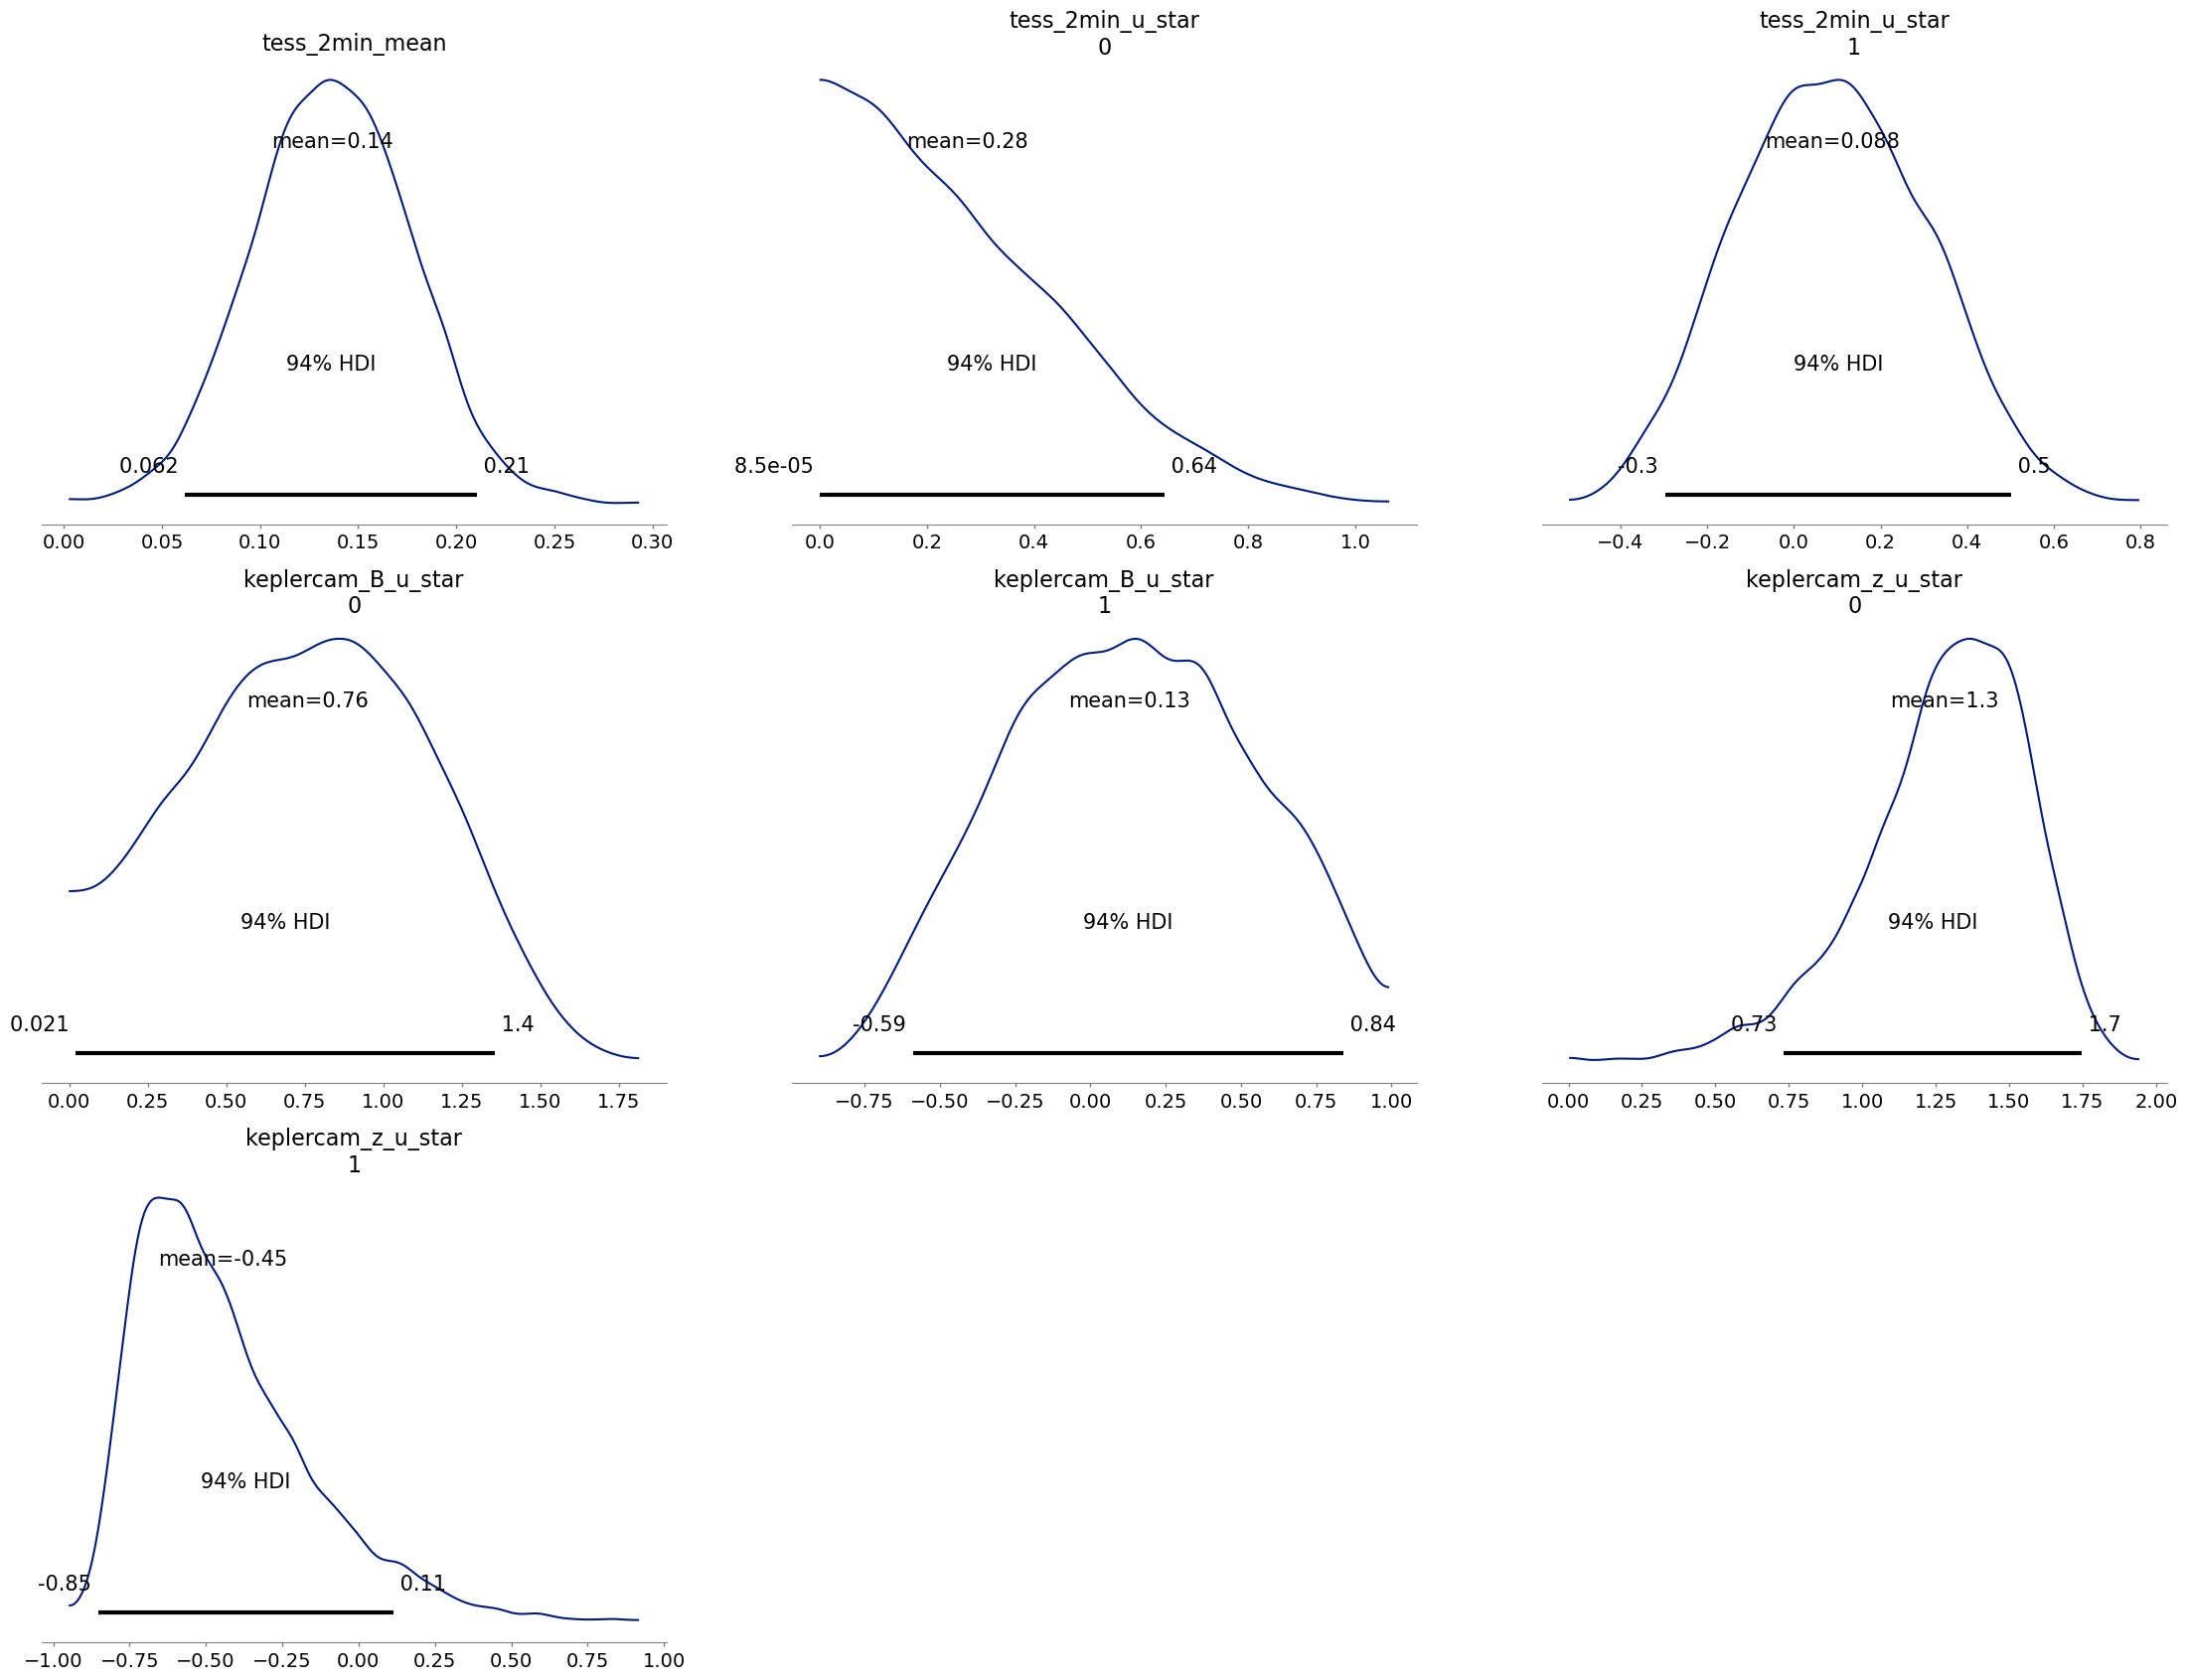

In [73]:
az.plot_posterior(trace, var_names=['tess_2min_mean', 'tess_2min_u_star', 'keplercam_B_u_star', 'keplercam_z_u_star'])
#plt.savefig('toi1199_ustar_posteriors.png', dpi=300, bbox_inches='tight')

In [74]:
from uncertainties import ufloat
from uncertainties.umath import *

logsigma_rv_mean = trace.posterior["log_sigma_rv"].median().item()
logsigma_rv = ufloat(logsigma_rv_mean, trace.posterior["log_sigma_rv"].std().item())
rv_jitter_ = np.e**logsigma_rv
# tess_jitter_median = trace.posterior['logs'].median().item()
# tess_jitter = ufloat(tess_jitter_median, trace.posterior['logs'].std().item())
# tess_jitter_val = np.e**tess_jitter
tess_2min_jitter_median = trace.posterior['tess_2min_logs'].median().item()
tess_2min_jitter = ufloat(tess_2min_jitter_median, trace.posterior['tess_2min_logs'].std().item())
tess_2min_jitter_val = np.e**tess_2min_jitter
tess_30min_jitter_median = trace.posterior['tess_30min_logs'].median().item()
tess_30min_jitter = ufloat(tess_30min_jitter_median, trace.posterior['tess_30min_logs'].std().item())
tess_30min_jitter_val = np.e**tess_30min_jitter
keplercam_B_jitter_median = trace.posterior['keplercam_B_logs'].median().item()
keplercam_B_jitter = ufloat(keplercam_B_jitter_median, trace.posterior['keplercam_B_logs'].std().item())
keplercam_B_jitter_val = np.e**keplercam_B_jitter
keplercam_z_jitter_median = trace.posterior['keplercam_z_logs'].median().item()
keplercam_z_jitter = ufloat(keplercam_z_jitter_median, trace.posterior['keplercam_z_logs'].std().item())
keplercam_z_jitter_val = np.e**keplercam_z_jitter
print("RV jitter = ", rv_jitter_)
print("TESS 2min jitter = ", tess_2min_jitter_val)
print("TESS 30min jitter = ", tess_30min_jitter_val)
print("Keplercam B jitter = ", keplercam_B_jitter_val)
print("Keplercam z jitter = ", keplercam_z_jitter_val)
print((trace.posterior["ror"].median().item())**2)

RV jitter =  10.2+/-1.1
TESS 2min jitter =  0.17+/-0.08
TESS 30min jitter =  0.13+/-0.06
Keplercam B jitter =  1.18+/-0.12
Keplercam z jitter =  1.55+/-0.13
0.004403340040325623


Parámetros

In [75]:
import math
radio = ufloat((trace.posterior["r_pl"].median().item()*u.R_sun).to(u.R_jup).value, (trace.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value)
b = ufloat(trace.posterior["b"].median().item(), trace.posterior["b"].std().item())
K = ufloat(trace.posterior["K"].median().item(), trace.posterior["K"].std().item())
eccen = ufloat(trace.posterior["ecc"].median().item(), trace.posterior["ecc"].std().item())
omega = ufloat(trace.posterior["omega"].median().item(), trace.posterior["omega"].std().item())
periodo = ufloat(trace.posterior['period'].median().item()*u.day.to(u.second),trace.posterior['period'].std().item()*u.day.to(u.second))
t_0 = ufloat(trace.posterior['t0'].median().item()+ref_time, trace.posterior['t0'].std().item())
G = 6.6743e-11
teff = ufloat(5700,66)
mstar = ufloat(trace.posterior['m_star'].median().item()*u.M_sun.to(u.kg), trace.posterior['m_star'].std().item()*u.M_sun.to(u.kg))
rstar = ufloat(trace.posterior['r_star'].median().item()*u.R_sun.to(u.au), trace.posterior['r_star'].std().item()*u.R_sun.to(u.au))
msini = K*sqrt(1-eccen**2)*(periodo*mstar**2/(2*np.pi*G))**(1/3)*u.kg.to(u.M_jup)
#msini = K**(periodo*mstar**2/(2*np.pi*G))**(1/3)*u.kg.to(u.M_jup)
smaxis = (periodo**2*G*(mstar+msini)/(4*np.pi**2))**(1/3)*u.m.to(u.au)
teq = teff*(rstar/smaxis)**(1/2)*(1/4)**(1/4)
densidad = msini*u.M_jup.to(u.g) * 1/(4 / 3 * np.pi * (radio*u.R_jup.to(u.cm))**3)
print("Rp = {r:.3f} Rj".format(r=radio))
print("b = {b:.3f}".format(b=b))
print("e = {e:.6f}".format(e=eccen))
print("omega = {w:.6f}".format(w=omega))
print("P = {p:.6f} days".format(p=periodo*u.second.to(u.day)))
print("Epoca = {e:.5f}".format(e=t_0))
print('a = {s:.4f} au'.format(s=smaxis))
print('Teq = {t:.3f} K'.format(t=teq))
print('m_pl = {m:.3f} Mj'.format(m=msini))
print('K = {k:.3f} m/s'.format(k=K))
print('densidad = {d:.3f} g/cm^3'.format(d=densidad))

Rp = 0.938+/-0.033 Rj
b = 0.852+/-0.017
e = 0.032051+/-0.030662
omega = 1.141073+/-1.712710
P = 3.671463+/-0.000003 days
Epoca = 2420.53765+/-0.00037
a = 0.0492+/-0.0003 au
Teq = 1492.328+/-28.994 K
m_pl = 0.233+/-0.018 Mj
K = 27.545+/-2.084 m/s
densidad = 0.351+/-0.046 g/cm^3


In [76]:
# resultados sin los sectores de 30 min
# Rp = 0.945+/-0.034 Rj
# b = 0.856+/-0.013
# e = 0.027714+/-0.026523
# omega = 0.841376+/-1.796590
# P = 3.671472+/-0.000012 days
# Epoca = 2420.53748+/-0.00046
# a = 0.0492+/-0.0003 au
# Teq = 1495.749+/-28.132 K
# m_pl = 0.233+/-0.018 Mj
# K = 27.517+/-2.090 m/s
# densidad = 0.342+/-0.045 g/cm^3

Traceplot

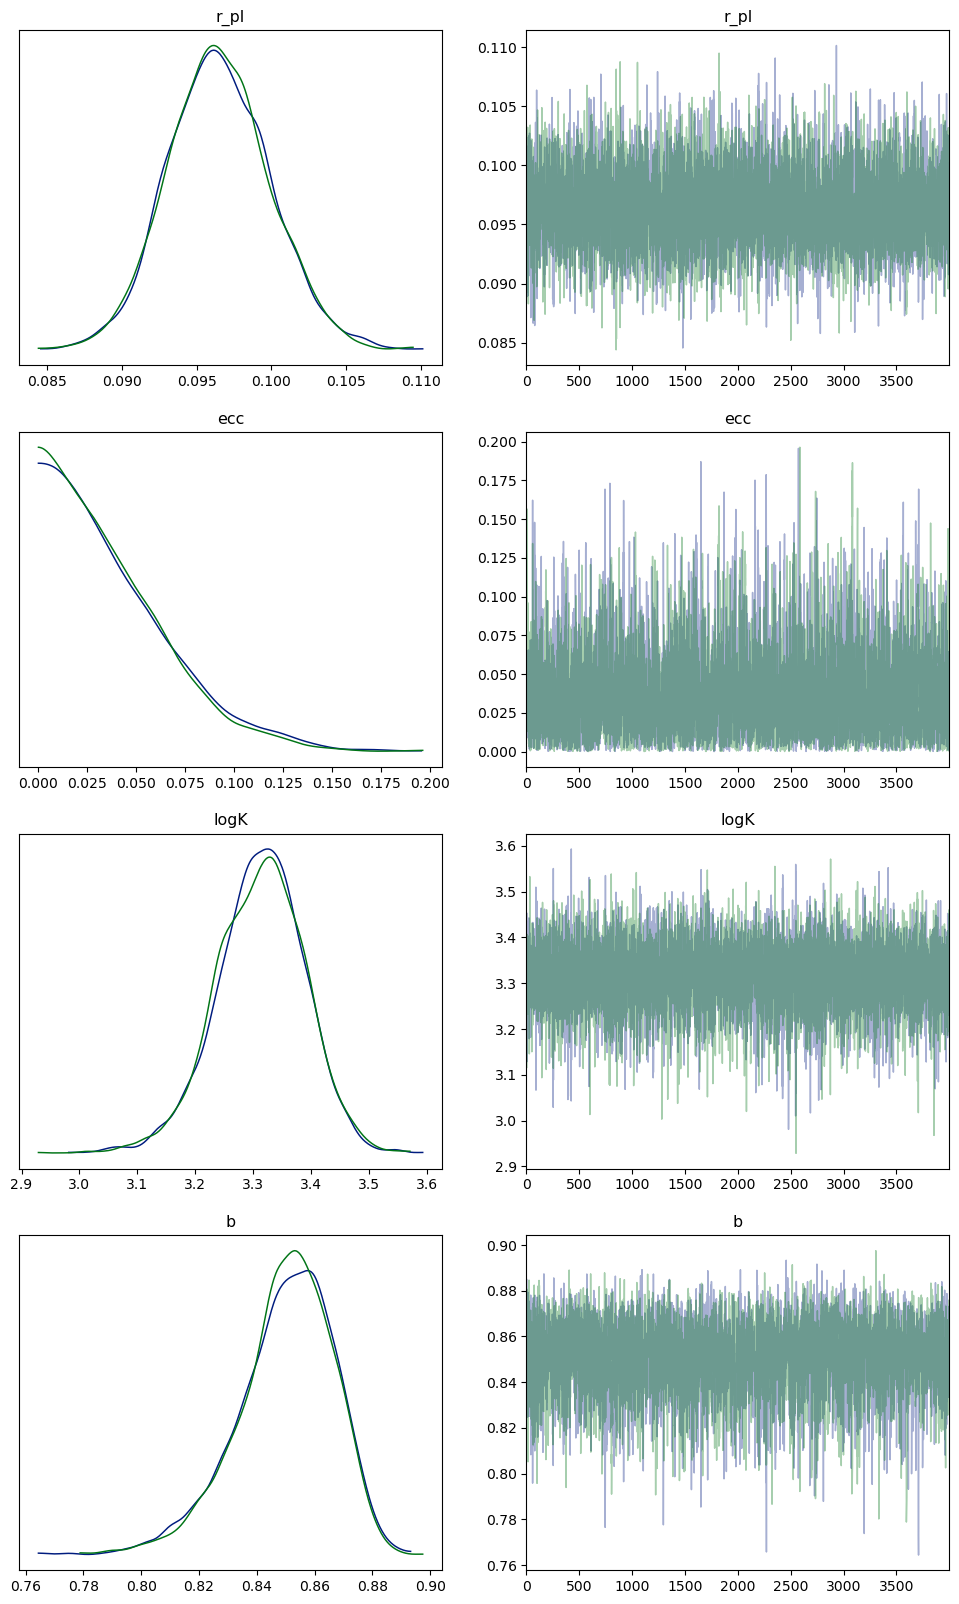

In [77]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

_ = az.plot_trace(trace, var_names=['r_pl', 'ecc','logK', 'b'] #log_depth or log_ror
                                    , compact=False, figsize=(12,20)) # SAMPLED 1 #ror instead of log_depth
# _ = az.plot_trace(trace, var_names=['log_period', 'log_m_pl', 't0', 'r_star', 'm_star']
#                                    , compact=False, figsize=(12,20)) # SAMPLED 2
# _ = az.plot_trace(trace, var_names=['ecs', 'b', 'u_star', 'mean']
#                                    , compact=False, figsize=(12,25)) # SAMPLED 3
# plt.savefig('trace_joint_1199_1.png',dpi=200,bbox_inches='tight')

In [78]:
trace3 = trace.copy()
trace3.posterior['r_pl'] = trace3.posterior['r_pl']*9.73116

In [79]:
CORNER_KWARGS = dict(
    smooth=0.5,
    plot_density=True,
    plot_datapoints=True,
    fill_contours=False,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

<Figure size 1400x1400 with 0 Axes>

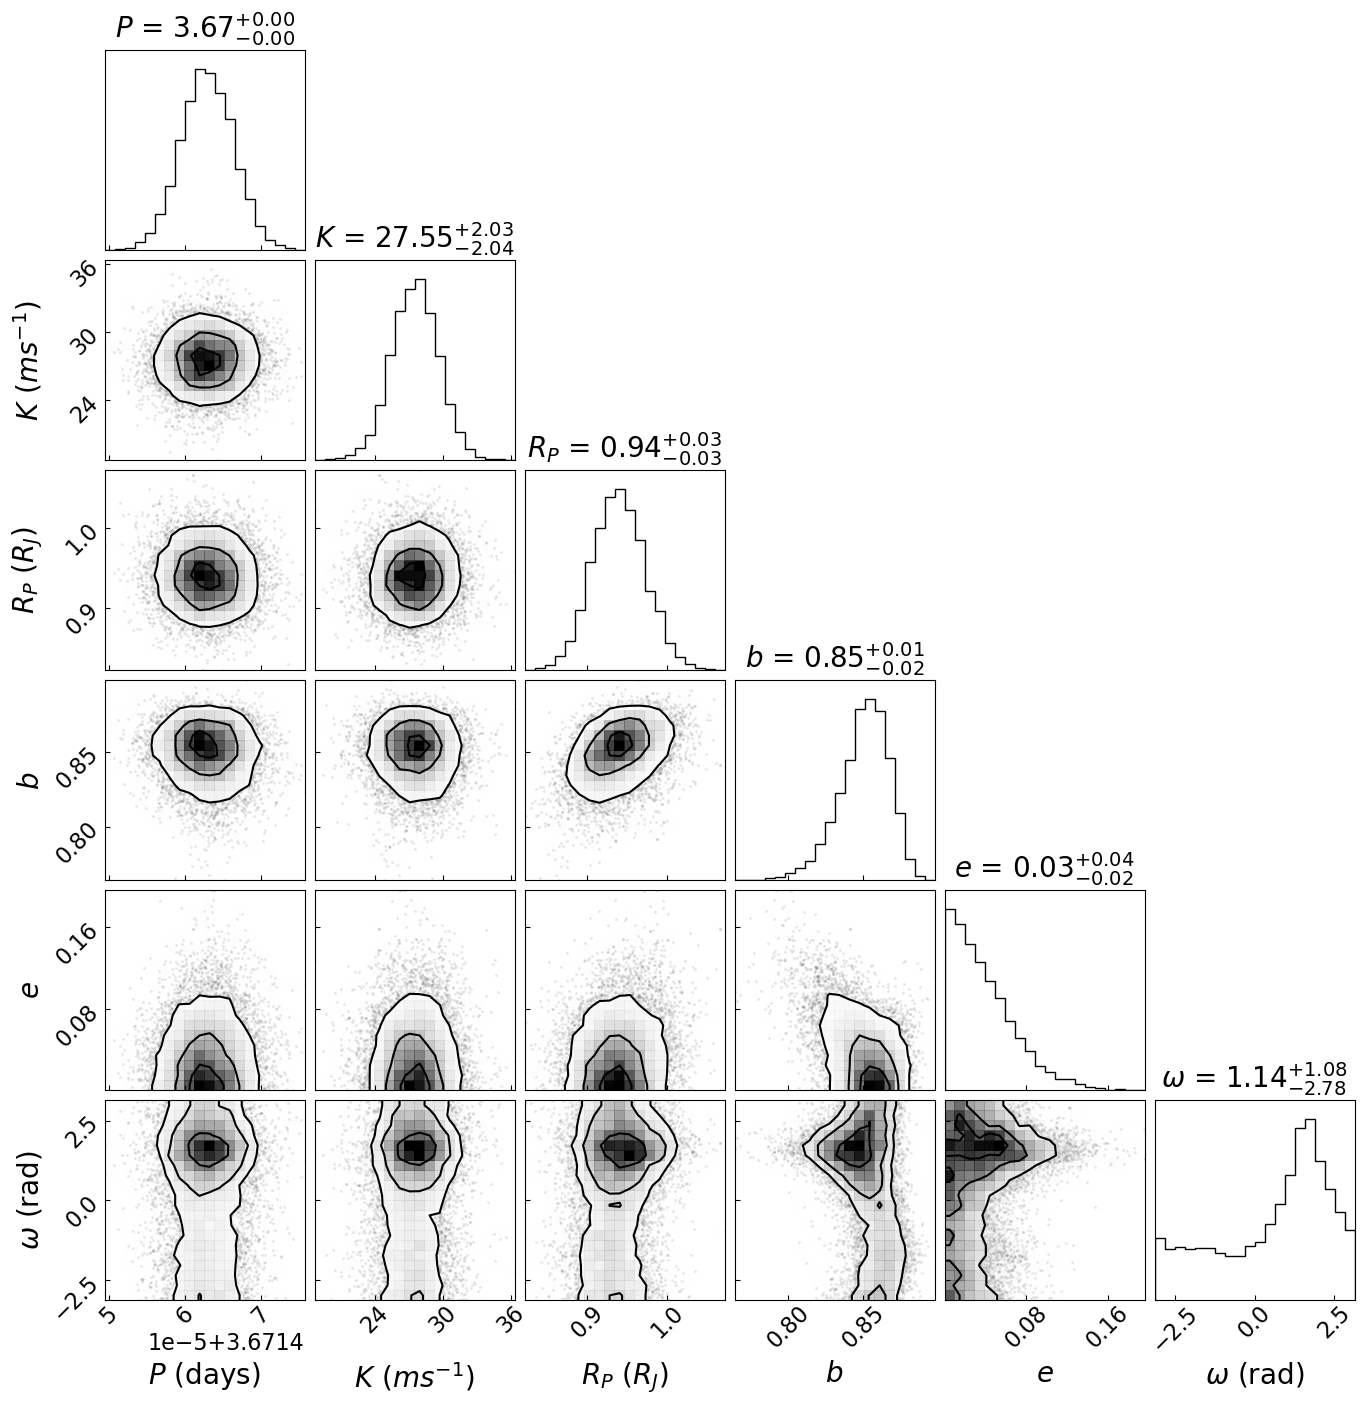

In [80]:
from cProfile import label
import corner
plt.figure(figsize=(14,14))
# figure = corner.corner(trace3, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
#                         labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
#                         show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
#                         labelpad=0, color='C2', quantiles=[0.16, 0.5, 0.84], **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
figure = corner.corner(trace3, var_names=['period', 'K', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
                        labels=[r"$P~$(days)", r"$K ~(ms^{-1})$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
                        show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$P$', '$K$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
                        labelpad=0, color='k', **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
for ax in figure.get_axes():
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
#plt.savefig('corner_1199_paper.png',dpi=300,bbox_inches='tight', facecolor='w')
plt.show()

## LC Phase plot

In [81]:
colormap1 = ['#FFEE58', '#FFEE58', '#5C6BC0', '#4FC3F7', '#FFB74D', '#FF8A65', '#F44336', '#A1887F']

In [82]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p_ = np.median(flat_samps["period"])
p_err = np.std(flat_samps["period"])
t0_ = np.median(flat_samps["t0"])
t0_err = np.std(flat_samps["t0"])
tess_2min_mean = np.median(flat_samps["tess_2min_mean"])
tess_30min_mean = np.median(flat_samps["tess_30min_mean"])
keplercam_B_mean = np.median(flat_samps["keplercam_B_mean"])
keplercam_z_mean = np.median(flat_samps["keplercam_z_mean"])

0.13649885372672424
0.09039050724170464
0.12306936390133731
0.08319005070458545


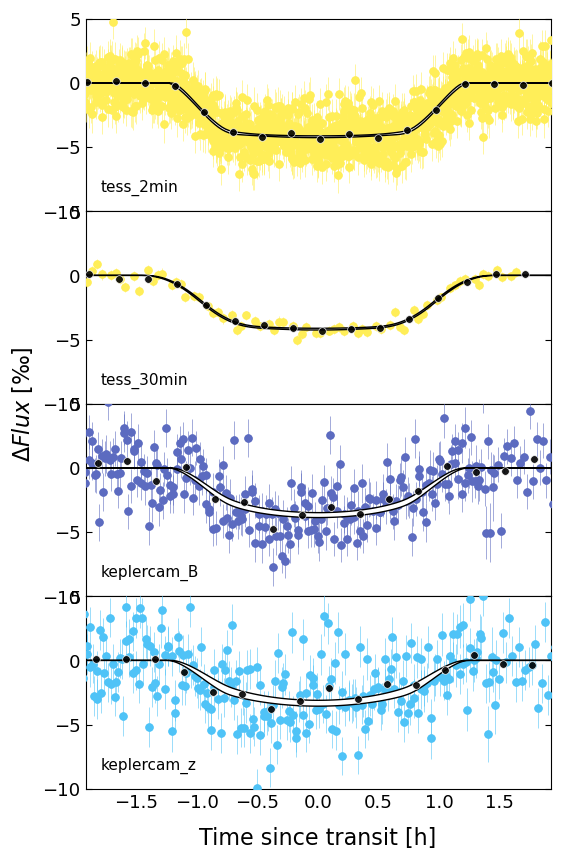

In [137]:
fig, axes = plt.subplots(len(datasets), sharex=True, sharey=True, figsize=(6, 10))
plt.subplots_adjust(hspace=0.0)
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time since transit [h]")
plt.ylabel(u'$\Delta Flux$ [‰]')
for n, name in enumerate(datasets):
    ax = axes[n]
    # plot the folded transits
    x, y, yerr = datasets[name][:3]
    folded = (x - t0_ + 0.5 * p_) % p_ - 0.5 * p_
    mean = np.median(flat_samps[f"{name}_mean"])
    print(mean)
    ax.plot(folded*24, (y  - mean), marker='o', ls='none', color=colormap1[n], 
            mec=colormap1[n], mew=1, alpha=1, label=f"{name}", ms=5, zorder=8)
    ax.errorbar(folded*24, (y  - mean), yerr=yerr, fmt='o', color=colormap1[n],
                alpha=0.8, ms=5, zorder=8, elinewidth=0.5, capsize=0)
    # Overplot the phase binned light curve 
    lcc = lk.LightCurve(time=folded, flux=y - mean, flux_err=yerr)
    lcc_binned = lcc.bin(time_bin_size=0.01)
    ax.scatter(lcc_binned['time'].value*24, lcc_binned['flux'].value, marker='o', s=30,  edgecolors='w', linewidths=0.5, c='k', alpha=0.9, zorder=12)
    # overplot the model
    pred = np.percentile(flat_samps[f"{name}_lc_pred"], [16, 50, 84], axis=-1)
    #ax.plot(phase_lc*24, pred[1], color="k", linewidth=1, alpha=1, zorder=11) #f"C{n+1}"
    art = ax.fill_between(phase_lc*24, pred[0], pred[2], color="w", alpha=1, zorder=10)
    art.set_edgecolor("k")
    ax.legend(fontsize=11, loc=3, frameon=False, handlelength=0, handletextpad=0, borderpad=0.5, markerscale=0)
    ax.tick_params(axis='y', which='major', size=4, left=True, right=True, direction='in', labelsize=13)
    ax.tick_params(axis='y', which='minor', size=2, left=True, right=True, direction='in', labelsize=13)
    ax.tick_params(axis='x', which='major', size=4, bottom=False, top=False, direction='in', labelsize=13)
    if n==5:
        ax.tick_params(axis='x', which='major', size=2, bottom=True, top=False, direction='in', labelsize=13)

axes[-1].set_xlim(-0.08*24, 0.08*24)
axes[-1].set_ylim(-10, 5)

#plt.savefig('1199_lcsfit.png', dpi=300, bbox_inches='tight')
plt.show()

## RV Phase plot

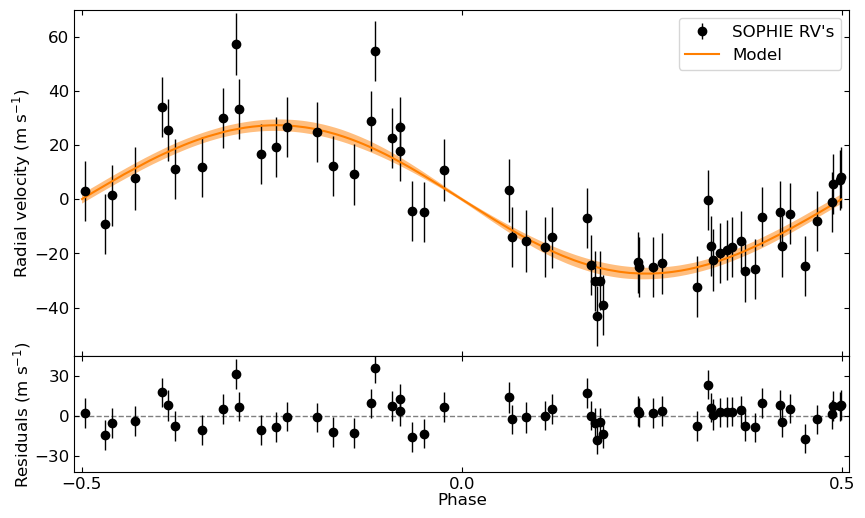

In [136]:
rv_jitter = np.exp(np.median(flat_samps['log_sigma_rv']))
bkg_ = np.median(flat_samps['bkg'].values, axis=-1)
rv_model_ = np.median(flat_samps['rv_model'].values, axis=-1)

# Plot the folded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3,1]})
fig.subplots_adjust(hspace=0.0)
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax1.errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='k', 
            markeredgecolor='k', ecolor='k', elinewidth=1, label='SOPHIE RV\'s', alpha=1) #color='#FBC15E'

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
ax1.plot(t_fold[inds]/p_, pred[1], color="#FF7F00", label="Model")
art = ax1.fill_between(t_fold[inds]/p_, pred[0], pred[2], color="#FF7F00", alpha=0.5) #color="#988ED5"
art.set_edgecolor("none")

ax1.set_xlim(-0.51, 0.51)
ax1.set_ylim(-58, 70)
ax1.set_ylabel("Radial velocity (m s$^{-1}$)", labelpad=1, fontsize=12)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], fontsize=12, loc='best')
ax1.tick_params(axis='both', which='both', left=True, bottom=True, top=True, right=True, direction='in', labelsize=12)

# Plot the folded residuals
ax2.axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5)
ax2.errorbar(x_fold/p_, y_rv-rv_model_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='k',
            markeredgecolor='k', ecolor='k', elinewidth=1, alpha=1, label='residuals')
ax2.set_ylabel('Residuals (m s$^{-1}$)', labelpad=1, fontsize=12)
ax2.set_xlabel("Phase", labelpad=1, fontsize=12)
ax2.tick_params(axis='both', which='both', left=True, bottom=True, top=True, right=True, direction='in', labelsize=12)
ax2.set_xlim(-0.51, 0.51)
ax2.set_ylim(-42, 45)
ax2.set_xticks([-0.5, 0, 0.5])
ax2.set_yticks([-30, 0, 30])
#plt.savefig('1199_rvs_fit.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### Periodograms with residues

In [85]:
ls_res = LombScargle(data.bjd, y_rv-rv_model_)
frequency_res, power_res = ls_res.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)
faps_res = ls_res.false_alarm_level(probabilities)  

/tmp/ipykernel_26218/2905182458.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([0.2,0.4,0.6,0.8,1.0])


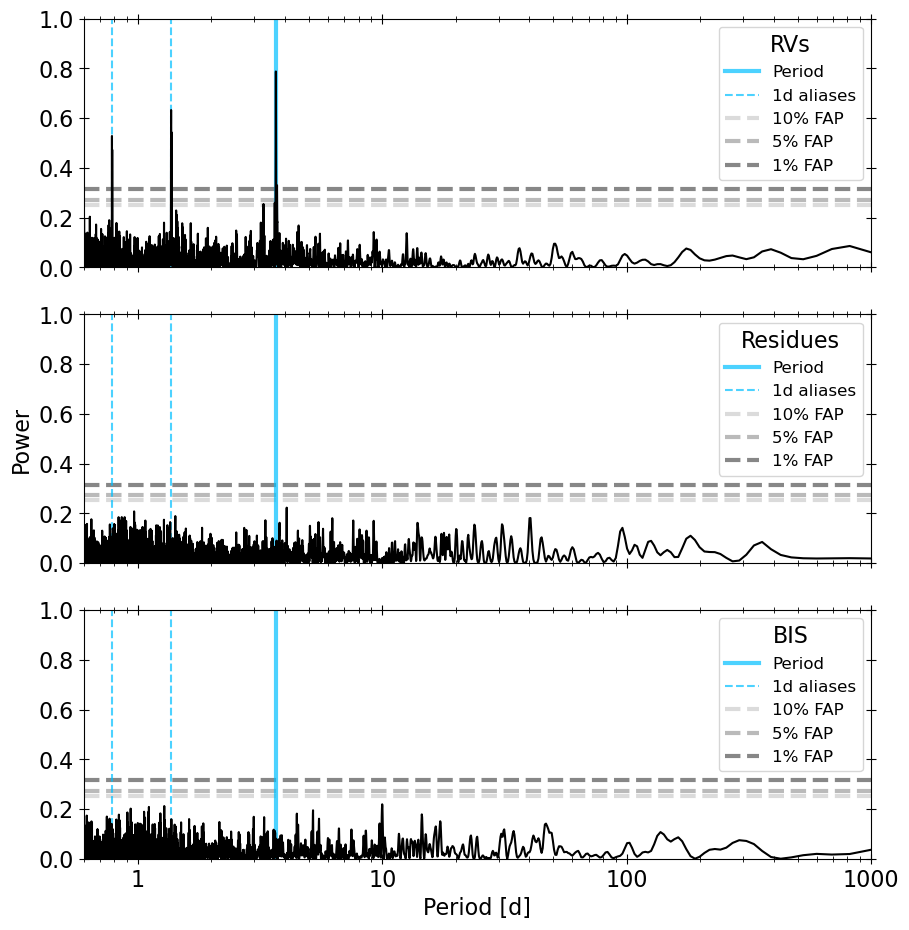

In [86]:
from matplotlib.ticker import ScalarFormatter
# plot two figures in a column
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 10), tight_layout=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
axes[0].plot(1/frequency, power, color='k', lw=1.5, zorder=10) 
axes[1].plot(1/frequency_res, power_res, color='k', lw=1.5, zorder=10)
axes[2].plot(1/frequency_bis, power_bis, color='k', lw=1.5, zorder=10) 

# plot the 'bls_period' as a vertical line behind the plot and show in legend
axes[0].axvline(p_, ls='-', lw=3, alpha=0.7, color='deepskyblue', label='Period', zorder=-10)
axes[1].axvline(p_, ls='-', lw=3, alpha=0.7, color='deepskyblue', label='Period', zorder=-10)
axes[2].axvline(p_, ls='-', lw=3, alpha=0.7, color='deepskyblue', label='Period', zorder=-10)

# add the aliases as red dashed vertical lines
for i in range(3):
    axes[i].axvline(aliases[0], lw=1.5, alpha=0.7, ls='--', color='deepskyblue', label='1d aliases')
    axes[i].axvline(aliases[2], lw=1.5, alpha=0.7, ls='--', color='deepskyblue')

# overplot the false alarm probabilities
names2 = [faps, faps_res, faps_bis]
for i, names in enumerate(names2):
    axes[i].axhline(names[0], ls='--', lw=3, alpha=0.8, color='lightgray', label='10% FAP', zorder=-20)
    axes[i].axhline(names[1], ls='--', lw=3, alpha=0.8, color='darkgray', label='5% FAP', zorder=-20)
    axes[i].axhline(names[2], ls='--', lw=3, alpha=0.8, color='dimgray', label='1% FAP', zorder=-20)

axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')

axes[0].set_xticklabels([0.2,0.4,0.6,0.8,1.0])
# set legends for all plots in the top right corner
axes[0].legend(loc='upper right', fontsize=12)
axes[1].legend(loc='upper right', fontsize=12)
axes[2].legend(loc='upper right', fontsize=12)
# add legend title
axes[0].legend(loc='upper right', fontsize=12, title='RVs')
axes[1].legend(loc='upper right', fontsize=12, title='Residues')
axes[2].legend(loc='upper right', fontsize=12, title='BIS')
axes[0].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[1].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[2].tick_params(axis='both', which='major', size=7, top=True, right=True, direction='inout')
axes[0].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')
axes[1].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')
axes[2].tick_params(axis='both', which='minor', size=5, top=True, right=True, direction='inout')

formatter = ScalarFormatter()
axes[0].xaxis.set_major_formatter(formatter)
axes[1].xaxis.set_major_formatter(formatter)
axes[2].xaxis.set_major_formatter(formatter)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Period [d]")
plt.ylabel("Power")
#plt.savefig('periodograms_1199.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [87]:
# esto lo hice para hacer la tabla de rvs en el latex
# tabla = pd.read_table('./data/rvs/1199_final_rvs.dat', sep='\s+', header=0, names=['time', 'rv', 'rv_err', 'bis'])
# tabla2 = pd.read_table('./data/rvs/1273_final_rvs.dat', sep='\s+', header=0, names=['time', 'rv', 'rv_err', 'bis'])
# for i in range(4):
#     if i < 3:
#         tabla.insert(2*i+1, '&'+str(i), '&')
#         tabla2.insert(2*i+1, '&'+str(i), '&')
#     else:
#         tabla.insert(2*i+1, '&'+str(i), '\\\\')
#         tabla2.insert(2*i+1, '&'+str(i), '\\\\')

# tabla.to_csv('./data/rvs/latex_1199.txt', header=None, index=None, sep=' ', mode='w')
# tabla2.to_csv('./data/rvs/latex_1273.txt', header=None, index=None, sep=' ', mode='w')

## Fit figure paper

In [300]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(axis='both', which='major', size=3, left=True, right=True, top=True, bottom=True, direction='in', labelsize=11)
        ax.tick_params(axis='both', which='minor', size=1.5, left=True, right=True, top=True, bottom=True, direction='in', labelsize=11)
# format_axes(fig)


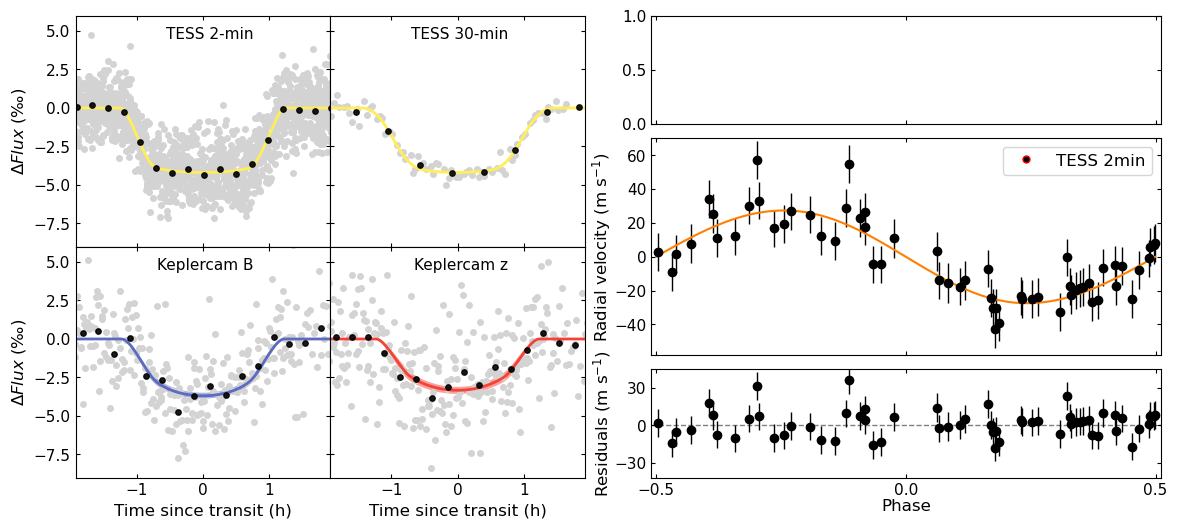

In [303]:
fig = plt.figure(figsize=(14, 6), constrained_layout=False)
outer_grid = fig.add_gridspec(4, 4, wspace=0.3, hspace=0)

inner_grid1 = outer_grid[0:2, 0:2].subgridspec(1, 2, wspace=0, hspace=0.1)
axs1 = inner_grid1.subplots(sharey=True)

inner_grid2 = outer_grid[2:4, 0:2].subgridspec(1, 2, wspace=0, hspace=0.1)
axs2 = inner_grid2.subplots(sharey=True)

inner_grid3 = outer_grid[0:4, 2:4].subgridspec(3, 1, wspace=0.1, hspace=0.1, height_ratios=[1, 2, 1])
axs3 = inner_grid3.subplots(sharex=True)

#tess 2 min
x1, y1, yerr1 = datasets['tess_2min'][:3]
x1_fold = (x1 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
axs1[0].plot(x1_fold*24, y1-tess_2min_mean, marker='o', ls='none', color='lightgrey', 
            mec='lightgrey', mew=1, alpha=1, label="TESS 2min", ms=4)
# axs1[0].errorbar(x1_fold*24, y1-tess_2min_mean, yerr=yerr1, fmt='o', color=colormap1[0],
#              alpha=0.8, ms=4, zorder=8, elinewidth=0.5, capsize=0)
lcc1 = lk.LightCurve(time=x1_fold, flux=y1-tess_2min_mean, flux_err=yerr1)
lcc1_binned = lcc1.bin(time_bin_size=0.01)
axs1[0].scatter(lcc1_binned['time'].value*24, lcc1_binned['flux'].value, marker='o', s=15,  
                c='k', alpha=0.9, zorder=12)
pred1 = np.percentile(flat_samps["tess_2min_lc_pred"], [16, 50, 84], axis=-1)
axs1[0].plot(phase_lc*24, pred1[1], color=colormap1[0], label="model", lw=2)
art = ax1.fill_between(phase_lc*24, pred1[0], pred1[2], color=colormap1[0], alpha=0.5)
art.set_edgecolor("none")
axs1[0].set_xlim(-0.08*24, 0.08*24)
axs1[0].set_ylim(-9, 6)
axs1[0].set_ylabel(u'$\Delta Flux$ (‰)', fontsize=12)
axs1[0].set_xlabel("Time since transit (h)", fontsize=12)
axs1[0].text(0.7, 0.9, 'TESS 2-min', transform=axs1[0].transAxes, fontsize=11, ha='right', fontweight='normal', fontfamily='sans-serif')

#tess 30 min
x2, y2, yerr2 = datasets['tess_30min'][:3]
x2_fold = (x2 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
axs1[1].plot(x2_fold*24, y2-tess_30min_mean, marker='o', ls='none', color='lightgrey',
            mec='lightgrey', mew=1, alpha=1, label="TESS 30min", ms=4)
# axs1[1].errorbar(x2_fold*24, y2-tess_30min_mean, yerr=yerr2, fmt='o', color=colormap1[1],
#              alpha=0.8, ms=4, zorder=8, elinewidth=0.5, capsize=0)
lcc2 = lk.LightCurve(time=x2_fold, flux=y2-tess_30min_mean, flux_err=yerr2)
lcc2_binned = lcc2.bin(time_bin_size=0.02)
axs1[1].scatter(lcc2_binned['time'].value*24, lcc2_binned['flux'].value, marker='o', s=15,
                c='k', alpha=0.9, zorder=12)
pred2 = np.percentile(flat_samps["tess_30min_lc_pred"], [16, 50, 84], axis=-1)
axs1[1].plot(phase_lc*24, pred2[1], color=colormap1[1], label="model", lw=2)
art = axs1[1].fill_between(phase_lc*24, pred2[0], pred2[2], color=colormap1[1], alpha=0.5)
art.set_edgecolor("none")
axs1[1].set_xlim(-0.08*24, 0.08*24)
axs1[1].set_ylim(-9, 6)
axs1[1].set_xlabel("Time since transit (h)", fontsize=12)
axs1[1].text(0.7, 0.9, 'TESS 30-min', transform=axs1[1].transAxes, fontsize=11, ha='right', fontweight='normal', fontfamily='sans-serif')

# keplercam_B
x3, y3, yerr3 = datasets['keplercam_B'][:3]
x3_fold = (x3 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
axs2[0].plot(x3_fold*24, y3-keplercam_B_mean, marker='o', ls='none', color='lightgrey',
            mec='lightgrey', mew=1, alpha=1, label="Keplercam B", ms=4)
# axs2[0].errorbar(x3_fold*24, y3-keplercam_B_mean, yerr=yerr3, fmt='o', color=colormap1[2],
#              alpha=0.8, ms=4, zorder=8, elinewidth=0.5, capsize=0)
lcc3 = lk.LightCurve(time=x3_fold, flux=y3-keplercam_B_mean, flux_err=yerr3)
lcc3_binned = lcc3.bin(time_bin_size=0.01)
axs2[0].scatter(lcc3_binned['time'].value*24, lcc3_binned['flux'].value, marker='o', s=15,
                c='k', alpha=0.9, zorder=12)
pred3 = np.percentile(flat_samps["keplercam_B_lc_pred"], [16, 50, 84], axis=-1)
axs2[0].plot(phase_lc*24, pred3[1], color=colormap1[2], label="model", lw=2)
art = axs2[0].fill_between(phase_lc*24, pred3[0], pred3[2], color=colormap1[2], alpha=0.5)
art.set_edgecolor("none")
axs2[0].set_xlim(-0.08*24, 0.08*24)
axs2[0].set_ylim(-9, 6)
axs2[0].set_ylabel(u'$\Delta Flux$ (‰)', fontsize=12)
axs2[0].set_xlabel("Time since transit (h)", fontsize=12)
axs2[0].text(0.7, 0.9, 'Keplercam B', transform=axs2[0].transAxes, fontsize=11, ha='right', fontweight='normal', fontfamily='sans-serif')

# keplercam_z
x4, y4, yerr4 = datasets['keplercam_z'][:3]
x4_fold = (x4 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
axs2[1].plot(x4_fold*24, y4-keplercam_z_mean, marker='o', ls='none', color='lightgrey',
            mec='lightgrey', mew=1, alpha=1, label="Keplercam z", ms=4)
# axs2[1].errorbar(x4_fold*24, y4-keplercam_z_mean, yerr=yerr4, fmt='o', color=colormap1[3],
#              alpha=0.8, ms=4, zorder=8, elinewidth=0.5, capsize=0)
lcc4 = lk.LightCurve(time=x4_fold, flux=y4-keplercam_z_mean, flux_err=yerr4)
lcc4_binned = lcc4.bin(time_bin_size=0.01)
axs2[1].scatter(lcc4_binned['time'].value*24, lcc4_binned['flux'].value, marker='o', s=15,
                c='k', alpha=0.9, zorder=12)
pred4 = np.percentile(flat_samps["keplercam_z_lc_pred"], [16, 50, 84], axis=-1)
axs2[1].plot(phase_lc*24, pred4[1], color=colormap1[6], label="model", lw=2)
art = axs2[1].fill_between(phase_lc*24, pred4[0], pred4[2], color=colormap1[6], alpha=0.5)
art.set_edgecolor("none")
axs2[1].set_xlim(-0.08*24, 0.08*24)
axs2[1].set_ylim(-9, 6)
axs2[1].set_xlabel("Time since transit (h)", fontsize=12)
axs2[1].text(0.7, 0.9, 'Keplercam z', transform=axs2[1].transAxes, fontsize=11, ha='right', fontweight='normal', fontfamily='sans-serif')

# RVs


# Plot the folded data
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
axs3[1].errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='k', 
            markeredgecolor='k', ecolor='k', elinewidth=1, label='SOPHIE RV\'s', alpha=1) 

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
axs3[1].plot(t_fold[inds]/p_, pred[1], color="#FF7F00", label="Model")
art = ax1.fill_between(t_fold[inds]/p_, pred[0], pred[2], color="#FF7F00", alpha=0.5) #color="#988ED5"
art.set_edgecolor("none")

axs3[1].set_xlim(-0.51, 0.51)
axs3[1].set_ylim(-58, 70)
axs3[1].set_ylabel("Radial velocity (m s$^{-1}$)", labelpad=1, fontsize=12)
handles, labels = ax1.get_legend_handles_labels()
axs3[1].legend(handles[::-1], labels[::-1], fontsize=12, loc='best')

# Plot the folded residuals
axs3[2].axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5)
axs3[2].errorbar(x_fold/p_, y_rv-rv_model_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='k',
            markeredgecolor='k', ecolor='k', elinewidth=1, alpha=1, label='residuals')
axs3[2].set_ylabel('Residuals (m s$^{-1}$)', labelpad=1, fontsize=12)
axs3[2].set_xlabel("Phase", labelpad=1, fontsize=12)
axs3[2].set_xlim(-0.51, 0.51)
axs3[2].set_ylim(-42, 45)
axs3[2].set_xticks([-0.5, 0, 0.5])
axs3[2].set_yticks([-30, 0, 30])


format_axes(fig)


# TTVs?

In [88]:
#t0_, p_
print(xlong_)
print(t0_)

[-844.60517911 -844.58434622 -844.56351333 ... -630.26475699 -630.243924
 -630.22309101]
-107.44984941465407


In [89]:
transit_times = xo.orbits.ttv.compute_expected_transit_times(-844, -100, p_, t0_)

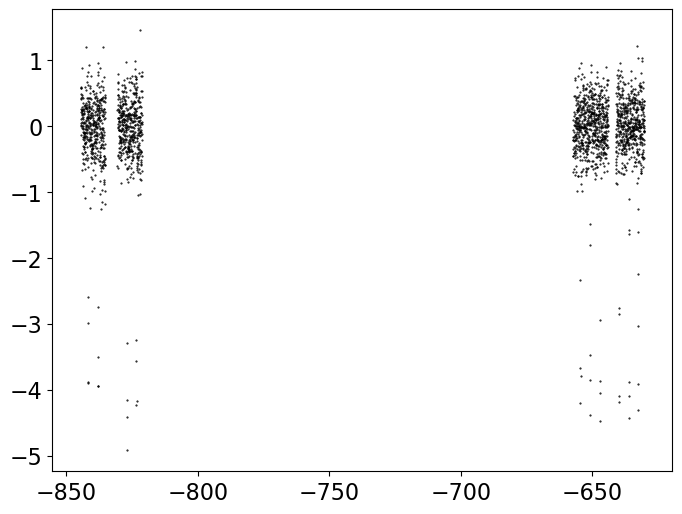

In [90]:
plt.plot(xlong_, ylong_, 'k.', ms=1)
# plt.xlim(-850,-840)

In [91]:
# un punto a la izquierda de cada transito, son 10
pcentros = [-633, -636.5, -640, -647.5, -651, -655, -823.5, -827.5, -838.5, -842 ]

In [92]:
# usemos uncertainties para propagar el error a Tc
t0_error = ufloat(t0_, t0_err)
p_error = ufloat(p_, p_err)

In [93]:
# define a list of 10 diferent colors
colorcycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

(-1.92, 1.92)

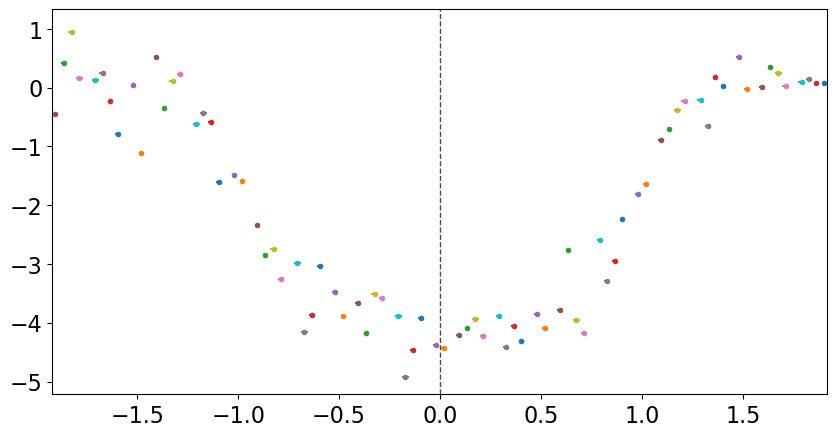

In [94]:
fig, ax = plt.subplots(figsize=(10, 5))
for n, i in enumerate(pcentros):
    npe = np.floor((i-t0_)/p_)+1
    tc = t0_error + p_error*(npe)
    xlong_2 = xlong_[np.abs(xlong_ - tc.nominal_value) < 0.08*p_]
    ylong_2 = ylong_[np.abs(xlong_ - tc.nominal_value) < 0.08*p_]
    yerrlong_2 = yerrlong_[np.abs(xlong_ + tc.nominal_value) < 0.08*p_]
    xlong_2_err = []
    for k in xlong_2:
        #xlong_2_err.append((k - tc)/p_error)
        xlong_2_err.append((k - npe*p_error-t0_))
    #ax.set_color_cycle([plt.cm.spectral(i) for i in np.linspace(0, 1, 10)])
    for r, m in enumerate(xlong_2_err):
        plt.errorbar(x=m.nominal_value*24, y=ylong_2[r], xerr=m.s*24, fmt='o', color=colorcycle[n], ms=3)
plt.axvline(0, color="k", ls='--', lw=1, alpha=0.7)
plt.xlim(-0.08*24, 0.08*24)
#plt.savefig('1199_ttvs.png', dpi=300, bbox_inches='tight')

# Additional LCs

CROW

In [95]:
#crow = pd.read_table('./data/photom/TOI1199/CROW/crow_measurements.dat')
crow = pd.read_table('./data/photom/TOI1199/CROW/TIC_99869022_01_20200204_CROW_g_measurements.tbl', sep='\s+')
# names of the columns are: 'rel_flux_T1_dn', 'rel_flux_err_T1_dn', 'BJD_TDB'

In [96]:
# crow['flux'] = ((crow['rel_flux_T1']/(crow['rel_flux_T1'].median())))*1e3
# crow['flux_err'] = ((crow['rel_flux_err_T1']/(crow['rel_flux_T1'].median())))*1e3
# crow['time'] = crow['BJD_TDB']-2457000-ref_time

crow['time'] = crow['BJD_TDB']-2457000-ref_time
crow['flux'] = crow['rel_flux_T1_dfn']
crow['flux_err'] = crow['rel_flux_err_T1_dfn']


In [97]:
#puntos?
print('puntos:', len(crow))
# texp?
print('texp:', np.median(np.diff(crow['BJD_TDB']))*24*60*60)

puntos: 64
texp: 278.9856120944023


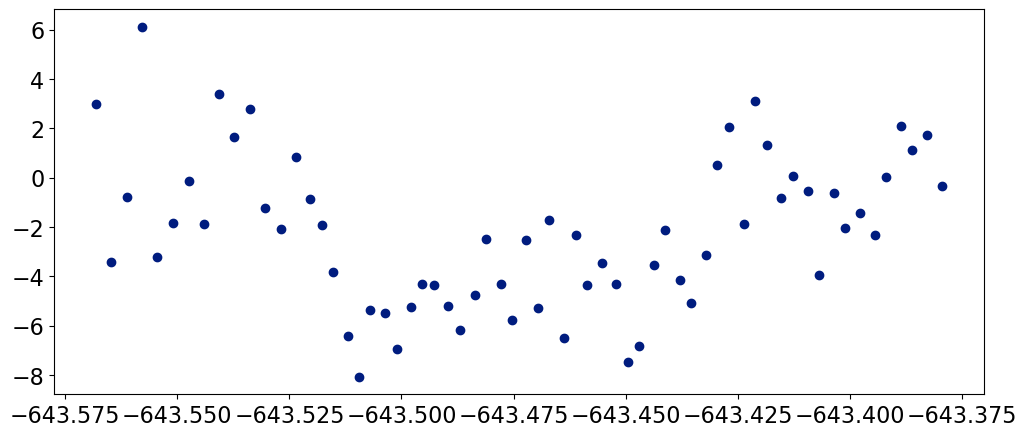

In [98]:
plt.subplots(figsize=(12,5))
plt.plot(crow['time'], (crow['flux']*1e3-1e3), 'o', label='CROW')
#plt.plot(crow['time'], crow2['rel_flux_T1_dn'], 'o', label='CROW')
#plt.ylim(-20,20)
plt.show()

In [99]:
from scipy.stats import binned_statistic
asd = binned_statistic(crow['time'], crow['rel_flux_T1_dn']*1e3-1e3, bins=len(crow)/2)
asd_time = binned_statistic(crow['time'], crow['time'], bins=len(crow)/2)
len(asd_time[0])

32

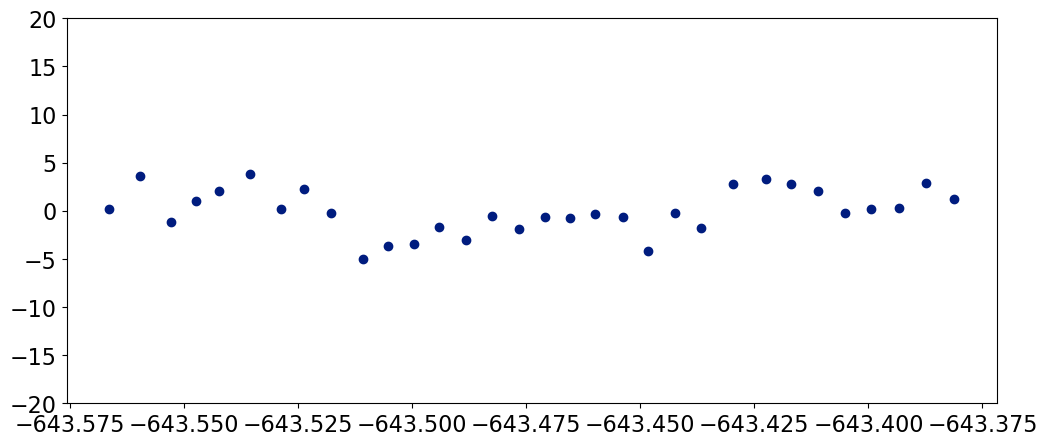

In [100]:
plt.subplots(figsize=(12,5))
plt.plot(asd_time[0], asd[0], 'o', label='cat')
plt.ylim(-20,20)
plt.show()

WBRO

In [101]:
wbro = pd.read_table('./data/photom/TOI1199/WBRO/TIC99869022-01_20200204_WBRO-24cm_R_measurements.tbl')

In [102]:
# wbro['flux'] = ((wbro['rel_flux_T1']/(wbro['rel_flux_T1'].median())))*1e3
# wbro['flux_err'] = ((wbro['rel_flux_err_T1']/(wbro['rel_flux_T1'].median())))*1e3
wbro['time'] = wbro['BJD_TDB']-2457000-ref_time

wbro['flux'] = wbro['rel_flux_T1_dfn']
wbro['flux_err'] = wbro['rel_flux_err_T1_dfn']

In [103]:
#puntos?
print('puntos:', len(wbro))
# texp?
print('texp:', np.median(np.diff(wbro['BJD_TDB']))*24*60*60)

puntos: 59
texp: 308.9664191007614


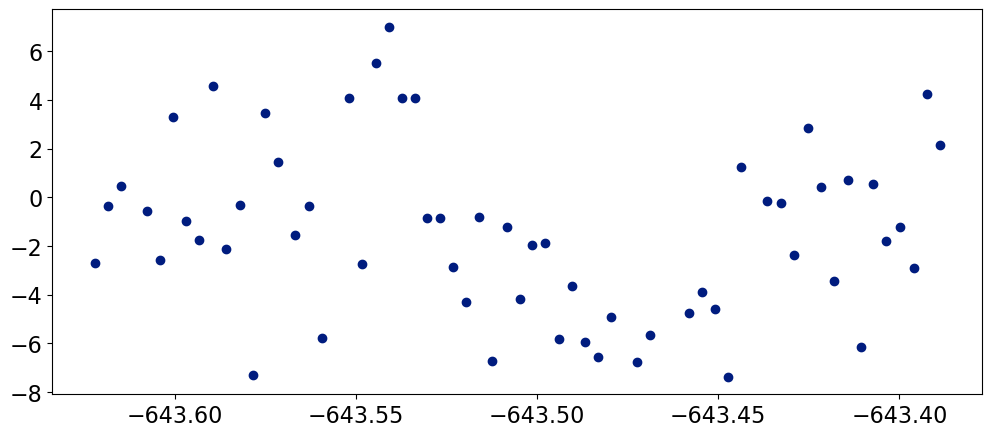

In [104]:
plt.subplots(figsize=(12,5))
plt.plot(wbro['time'], wbro['flux']*1e3-1e3, 'o', label='wbro')
plt.show()

WCO

In [105]:
wco = pd.read_table('./data/photom/TOI1199/WCO/TIC99869022-01_20201209_WCO_gp_measurements.tbl')

In [106]:
# wco['flux'] = ((wco['rel_flux_T1']/(wco['rel_flux_T1'].median())))
# wco['flux_err'] = ((wco['rel_flux_err_T1']/(wco['rel_flux_T1'].median())))
wco['time'] = wco['BJD_TDB']-2457000-ref_time
wco['flux'] = wco['rel_flux_T1_dfn']
wco['flux_err'] = wco['rel_flux_err_T1_dfn']

In [107]:
print('puntos:', len(wco))
print('texp:', np.median(np.diff(wco['BJD_TDB']))*24*60*60)

puntos: 216
texp: 88.0416065454483


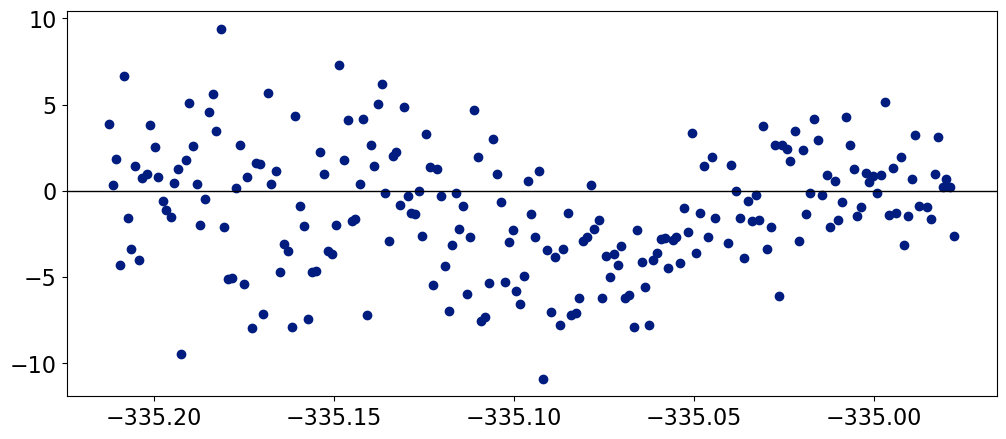

In [108]:
plt.subplots(figsize=(12,5))
plt.plot(wco['time'], wco['flux']*1e3-1e3, 'o', label='wco')
# horizontal line at 0
plt.axhline(0, color='k', lw=1)
plt.show()

## Extra LCs Phase plot

In [109]:
extra_datasets = OrderedDict(
    [
        ("CROW", [crow['time'], crow['flux']*1e3-1e3, crow['flux_err']*1e3]),
        ("WCO", [wco['time'], wco['flux']*1e3-1e3, wco['flux_err']*1e3]),
        ("WBRO", [wbro['time'], wbro['flux']*1e3-1e3, wbro['flux_err']*1e3])
    ]
)
# crow es g'
# wbro es R
# wco es g'

KeyError: 'muscat_g_mean'

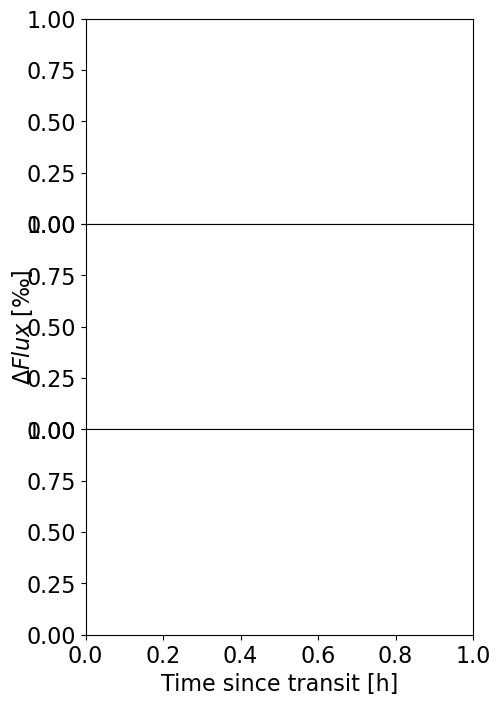

In [110]:
fig, axes = plt.subplots(3, sharex=True, sharey=True, figsize=(5, 8))
plt.subplots_adjust(hspace=0.0)
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axi
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time since transit [h]")
plt.ylabel(u'$\Delta Flux$ [‰]')
for n, name in enumerate(extra_datasets):
    ax = axes[n]
    # plot the folded transits
    x, y, yerr = extra_datasets[name][:3]
    folded = (x - t0_ + 0.5 * p_) % p_ - 0.5 * p_

    mean = np.median(flat_samps["muscat_g_mean"])
    ax.plot(folded*24, (y  - mean), marker='o', ls='none', color='k', 
        mec='k', mew=1, alpha=1, label=f"{name}"+" g'", ms=4, zorder=8)
    ax.errorbar(folded*24, (y  - mean), yerr=yerr, fmt='o', color='k',
            alpha=0.8, ms=4, zorder=8, elinewidth=0.5, capsize=0)

    pred = np.percentile(flat_samps["muscat_g_lc_pred"], [16, 50, 84], axis=-1)
    ax.plot(phase_lc*24, pred[1], color=colormap1[2], label="muscat g' model", 
            zorder=800, linewidth=1, alpha=1)
    art = ax.fill_between(phase_lc*24, pred[0], pred[2], color=colormap1[2], 
                          alpha=0.65, zorder=10)
    art.set_edgecolor("none")

    ax.legend(fontsize=11, loc=1, handlelength=0.5, handletextpad=0.5, borderpad=0.2, markerscale=0.8, 
                framealpha=1, frameon=False).set_zorder(11) 
    ax.tick_params(axis='y', which='major', size=4, left=True, right=True, direction='in', labelsize=13)
    ax.tick_params(axis='y', which='minor', size=2, left=True, right=True, direction='in', labelsize=13)
    ax.tick_params(axis='x', which='major', size=4, bottom=False, top=False, direction='in', labelsize=13)

axes[-1].set_xlim(-0.08*24, 0.08*24)
axes[-1].set_ylim(-12, 12)
#plt.savefig('1199_extralcs.png', dpi=300, bbox_inches='tight')
plt.show()